# 🎵 Segmentasi Musik Spotify Berbasis Audio Features Menggunakan K-Means Clustering

---

## Latar Belakang Masalah

Industri musik digital mengalami pertumbuhan eksponensial dengan jutaan lagu tersedia di platform streaming seperti Spotify. Tantangan utama yang dihadapi adalah bagaimana **mengorganisir dan mengkategorikan lagu-lagu** tersebut secara efektif untuk meningkatkan pengalaman pengguna melalui sistem rekomendasi yang personal.

Pendekatan tradisional menggunakan genre musik memiliki keterbatasan karena:
- Genre seringkali **subjektif** dan **tumpang tindih**
- Satu lagu dapat memiliki karakteristik dari beberapa genre
- Label genre tidak menangkap nuansa audio yang sebenarnya

Oleh karena itu, pendekatan berbasis **audio features** (karakteristik audio numerik) menjadi solusi yang lebih objektif dan terukur.

---

## Mengapa K-Means Clustering?

Pemilihan algoritma **K-Means** untuk proyek ini didasarkan pada beberapa alasan teknis:

| Aspek | Penjelasan |
|-------|------------|
| **Efisiensi Komputasi** | Kompleksitas O(N × K × I × D) dimana N=jumlah data, K=cluster, I=iterasi, D=dimensi. Sangat efisien untuk dataset besar (114K+ baris) |
| **Karakteristik Data Audio** | Fitur audio Spotify (danceability, energy, valence, dll) bersifat **continuous** dan **numeric**, cocok dengan asumsi K-Means yang berbasis jarak Euclidean |
| **Interpretabilitas** | Centroid cluster mudah diinterpretasi sebagai "profil musik" yang representatif |
| **Scalability** | Dapat di-scale dengan mudah menggunakan Mini-Batch K-Means jika data bertambah besar |

---

## Teknik Preprocessing: Yeo-Johnson Transformation

> 📌 **Catatan Penting**: Dalam proyek ini, kita menggunakan **PowerTransformer dengan metode Yeo-Johnson** untuk menormalkan distribusi data audio.

Yeo-Johnson Transformation dipilih karena:
- Dapat menangani data dengan **nilai negatif** (seperti loudness)
- Mengubah distribusi skewed menjadi **mendekati normal (Gaussian)**
- K-Means bekerja optimal dengan data yang terdistribusi normal

---

## Tujuan Proyek

1. **Melakukan segmentasi lagu** berdasarkan audio features menggunakan K-Means Clustering
2. **Menemukan jumlah cluster optimal** dengan pendekatan **Composite Score** yang menyeimbangkan metrik matematis dan business value
3. **Membuat profil karakteristik** setiap cluster musik yang terbentuk
4. **Memvalidasi hasil clustering** dengan membandingkan terhadap genre asli

> 💡 **Filosofi Proyek**: Kita mencari keseimbangan antara **skor matematis yang optimal** dan **Business Value** yang praktis. Cluster yang terlalu sedikit kurang informatif, sedangkan terlalu banyak sulit dikelola.

---

# Bagian 1: Data Loading & Cleaning

Pada bagian ini, kita akan memuat dataset Spotify dan melakukan pembersihan data dasar.

In [60]:
# Import Library yang Diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✅ Semua library berhasil diimpor!")
print("   • PowerTransformer (Yeo-Johnson) untuk normalisasi data")
print("   • t-SNE untuk visualisasi cluster 2D")

✅ Semua library berhasil diimpor!
   • PowerTransformer (Yeo-Johnson) untuk normalisasi data
   • t-SNE untuk visualisasi cluster 2D


## 1.1 Load Dataset

Memuat dataset Spotify Tracks dari Kaggle menggunakan `kagglehub`.

In [61]:
try:
    # Install dependencies as needed:
    # pip install kagglehub[pandas-datasets]
    import kagglehub
    from kagglehub import KaggleDatasetAdapter

    # Set the path to the file you'd like to load
    file_path = "dataset.csv"

    # Load the latest version
    df = kagglehub.load_dataset(
      KaggleDatasetAdapter.PANDAS,
      "maharshipandya/-spotify-tracks-dataset",
      file_path,
    )
    print("Data berhasil dimuat!")
except FileNotFoundError:
    print("File tidak ditemukan. Pastikan file dataset.csv ada di direktori yang sama.")

Data berhasil dimuat!


In [62]:
# Lihat 5 baris pertama
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## 1.2 Eksplorasi Struktur Data

Mari kita periksa informasi dasar tentang dataset.

In [63]:
# Informasi dataset
print("=" * 60)
print("INFORMASI DATASET")
print("=" * 60)
print(f"\n📊 Dimensi Dataset: {df.shape[0]:,} baris × {df.shape[1]} kolom\n")
print("-" * 60)
df.info()

INFORMASI DATASET

📊 Dimensi Dataset: 114,000 baris × 21 kolom

------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  floa

In [64]:
# Statistik deskriptif
df.describe()

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,56999.500000,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,32909.109681,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28499.750000,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,56999.500000,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,85499.250000,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


## 1.3 Data Cleaning

### Menghapus Duplikat berdasarkan `track_id`

Track ID adalah identifier unik untuk setiap lagu. Duplikat pada kolom ini menandakan data yang redundan.

In [65]:
# Cek duplikat berdasarkan track_id
print("=" * 60)
print("CEK DUPLIKAT DATA")
print("=" * 60)
print(f"\n📌 Jumlah data sebelum drop duplikat: {len(df):,}")
print(f"📌 Jumlah duplikat berdasarkan track_id: {df.duplicated(subset=['track_id']).sum():,}")

# Drop duplikat berdasarkan track_id
df = df.drop_duplicates(subset=['track_id'], keep='first').reset_index(drop=True)

print(f"📌 Jumlah data setelah drop duplikat: {len(df):,}")

CEK DUPLIKAT DATA

📌 Jumlah data sebelum drop duplikat: 114,000
📌 Jumlah duplikat berdasarkan track_id: 24,259
📌 Jumlah data setelah drop duplikat: 89,741


In [66]:
# Cek missing values
print("=" * 60)
print("CEK MISSING VALUES")
print("=" * 60)
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Kolom': missing.index,
    'Missing Count': missing.values,
    'Missing %': missing_pct.values
})

print(f"\n📌 Total Missing Values: {missing.sum()}")
if missing.sum() > 0:
    print("\n Detail kolom dengan missing values:")
    print(missing_df[missing_df['Missing Count'] > 0].to_string(index=False))
else:
    print("✅ Tidak ada missing values dalam dataset!")

CEK MISSING VALUES

📌 Total Missing Values: 3

 Detail kolom dengan missing values:
     Kolom  Missing Count  Missing %
   artists              1        0.0
album_name              1        0.0
track_name              1        0.0


---

# Bagian 2: Exploratory Data Analysis (EDA)

Pada bagian ini, kita akan mengeksplorasi karakteristik data untuk memahami distribusi dan hubungan antar fitur audio.

## 2.1 Distribusi Genre (Track Genre Balance)

Mari kita lihat seberapa balance distribusi genre dalam dataset.

DISTRIBUSI GENRE

📊 Jumlah genre unik: 113
📊 Rata-rata lagu per genre: 794
📊 Min lagu per genre: 74 (reggaeton)
📊 Max lagu per genre: 1000 (acoustic)


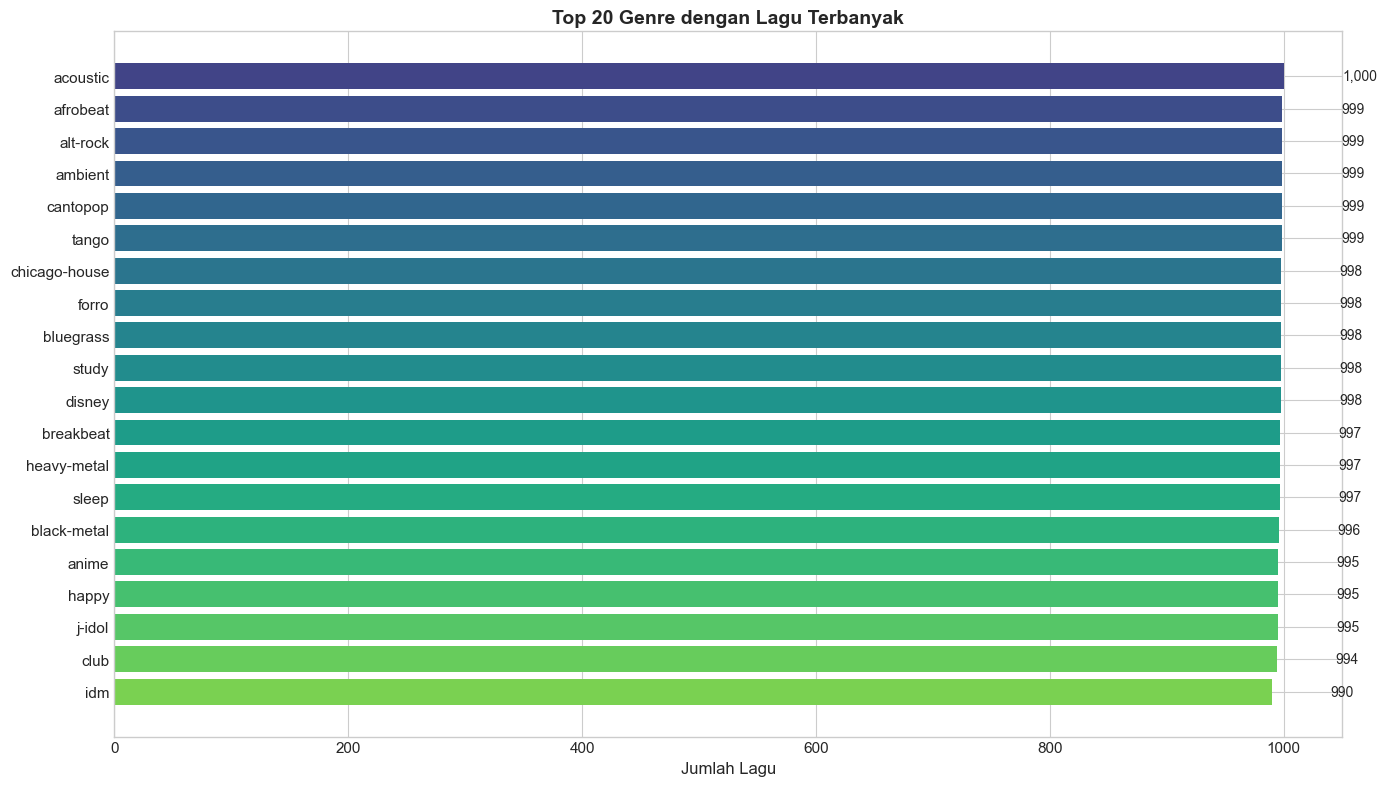


✅ Distribusi genre relatif seimbang - cocok untuk unsupervised learning


In [67]:
# Distribusi Genre
genre_counts = df['track_genre'].value_counts()

print("=" * 60)
print("DISTRIBUSI GENRE")
print("=" * 60)
print(f"\n📊 Jumlah genre unik: {len(genre_counts)}")
print(f"📊 Rata-rata lagu per genre: {genre_counts.mean():.0f}")
print(f"📊 Min lagu per genre: {genre_counts.min()} ({genre_counts.idxmin()})")
print(f"📊 Max lagu per genre: {genre_counts.max()} ({genre_counts.idxmax()})")

# Visualisasi Top 20 Genre
fig, ax = plt.subplots(figsize=(14, 8))
top_20_genres = genre_counts.head(20)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_20_genres)))

bars = ax.barh(range(len(top_20_genres)), top_20_genres.values, color=colors)
ax.set_yticks(range(len(top_20_genres)))
ax.set_yticklabels(top_20_genres.index)
ax.invert_yaxis()
ax.set_xlabel('Jumlah Lagu', fontsize=12)
ax.set_title('Top 20 Genre dengan Lagu Terbanyak', fontsize=14, fontweight='bold')

# Tambahkan label nilai
for i, (bar, val) in enumerate(zip(bars, top_20_genres.values)):
    ax.text(val + 50, i, f'{val:,}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✅ Distribusi genre relatif seimbang - cocok untuk unsupervised learning")

## 2.2 Distribusi Fitur Audio (Histogram)

Kita akan memvisualisasikan distribusi setiap fitur audio untuk memahami karakteristik dan potensi skewness.

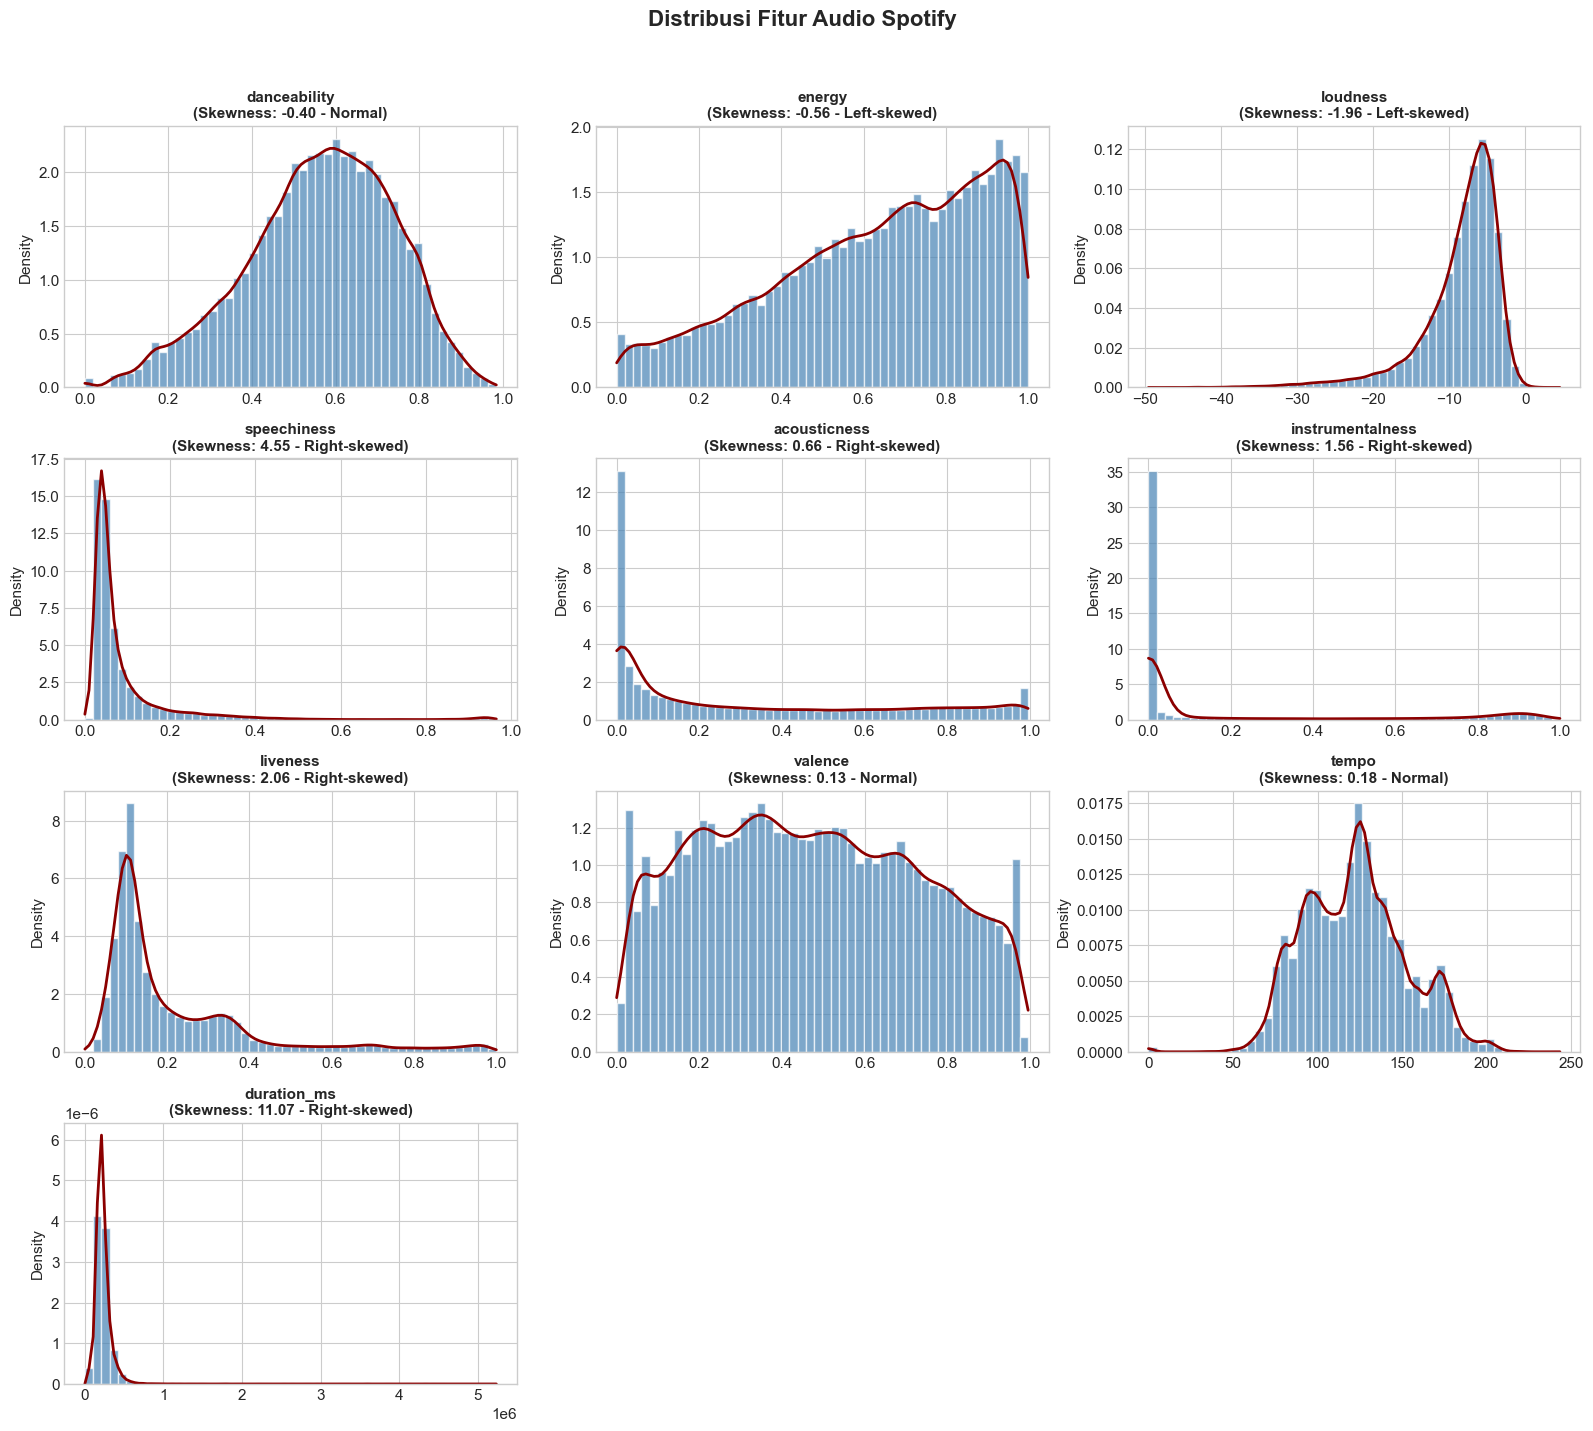


📝 CATATAN PENTING:
   • speechiness dan instrumentalness menunjukkan distribusi HIGHLY RIGHT-SKEWED
   • Perlu dipertimbangkan Log Transformation pada preprocessing


In [68]:
# Definisikan fitur audio yang akan dianalisis
audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 
                  'valence', 'tempo', 'duration_ms']

# Visualisasi Histogram untuk setiap fitur audio
fig, axes = plt.subplots(4, 3, figsize=(16, 14))
axes = axes.flatten()

for i, feature in enumerate(audio_features):
    ax = axes[i]
    
    # Histogram dengan KDE
    data = df[feature].dropna()
    ax.hist(data, bins=50, color='steelblue', alpha=0.7, edgecolor='white', density=True)
    
    # Tambahkan KDE line
    from scipy import stats
    kde_x = np.linspace(data.min(), data.max(), 100)
    kde = stats.gaussian_kde(data)
    ax.plot(kde_x, kde(kde_x), color='darkred', linewidth=2)
    
    # Hitung skewness
    skewness = data.skew()
    skew_label = "Normal" if abs(skewness) < 0.5 else ("Right-skewed" if skewness > 0 else "Left-skewed")
    
    ax.set_title(f'{feature}\n(Skewness: {skewness:.2f} - {skew_label})', fontsize=11, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Density')

# Hapus subplot kosong
for j in range(len(audio_features), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Distribusi Fitur Audio Spotify', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📝 CATATAN PENTING:")
print("   • speechiness dan instrumentalness menunjukkan distribusi HIGHLY RIGHT-SKEWED")
print("   • Perlu dipertimbangkan Log Transformation pada preprocessing")

## 2.3 Deteksi Outlier (Boxplot)

Boxplot membantu kita mengidentifikasi outlier pada setiap fitur audio.

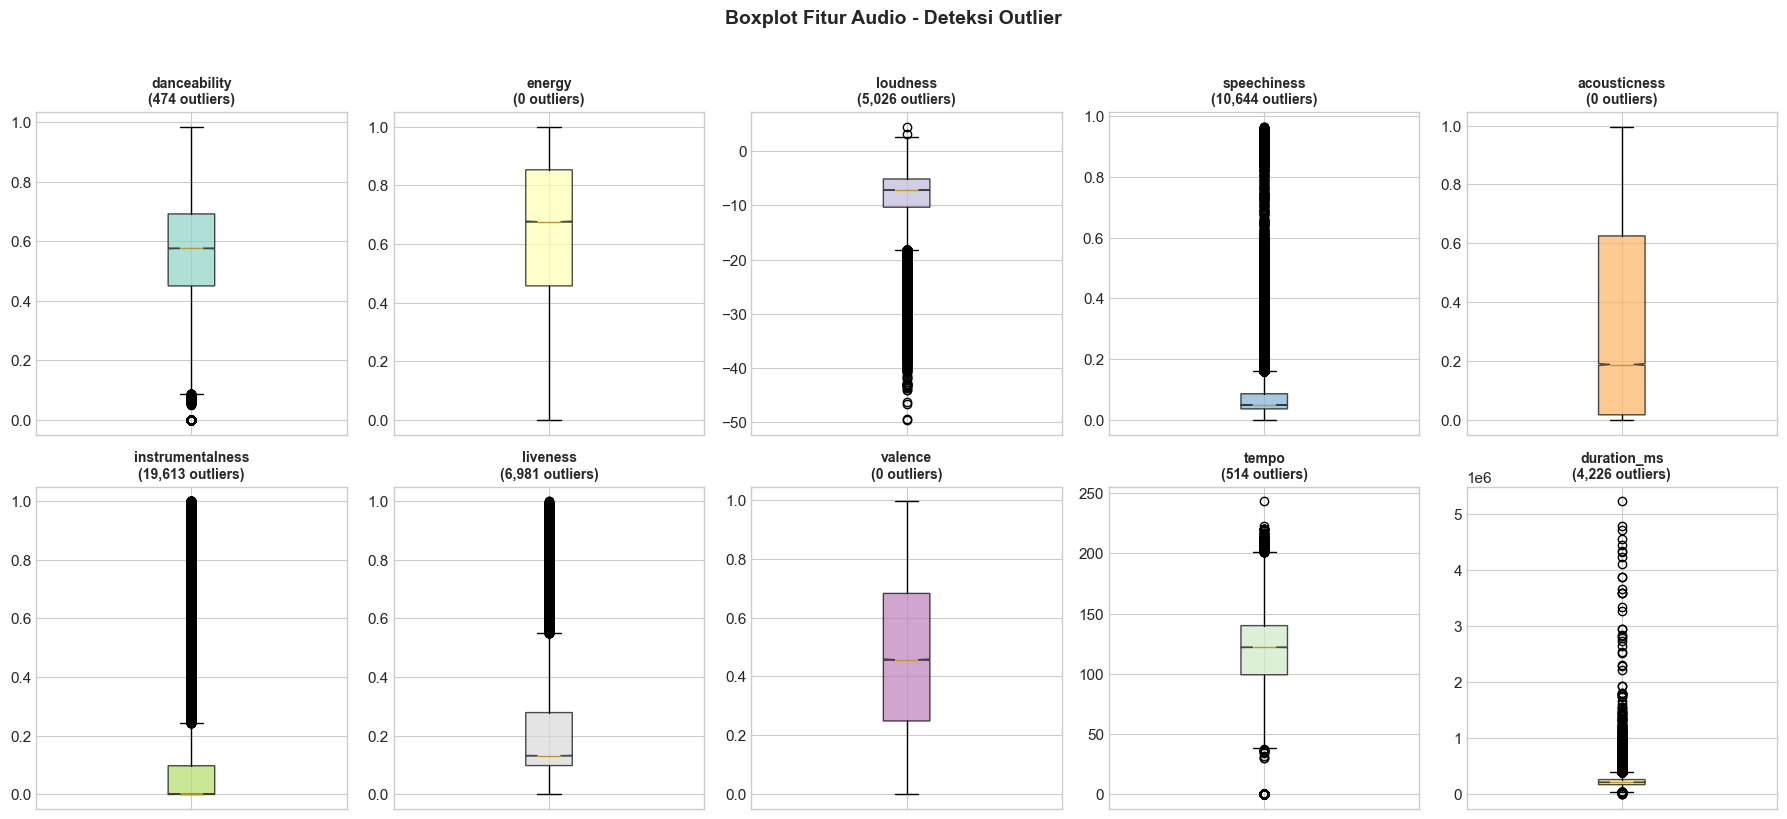


📝 CATATAN:
   • Outlier adalah bagian natural dari data musik
   • K-Means sensitif terhadap outlier, namun scaling dan PCA akan membantu mengurangi dampaknya
   • Kita tidak akan menghapus outlier karena bisa jadi lagu-lagu unik/experimental


In [69]:
# Boxplot untuk fitur audio
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

# Palette warna yang menarik
colors = plt.cm.Set3(np.linspace(0, 1, len(audio_features)))

for i, feature in enumerate(audio_features):
    ax = axes[i]
    bp = ax.boxplot(df[feature].dropna(), patch_artist=True, notch=True)
    bp['boxes'][0].set_facecolor(colors[i])
    bp['boxes'][0].set_alpha(0.7)
    
    # Hitung jumlah outlier menggunakan IQR method
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[feature] < Q1 - 1.5*IQR) | (df[feature] > Q3 + 1.5*IQR)][feature]
    
    ax.set_title(f'{feature}\n({len(outliers):,} outliers)', fontsize=10, fontweight='bold')
    ax.set_xticklabels([])

plt.suptitle('Boxplot Fitur Audio - Deteksi Outlier', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📝 CATATAN:")
print("   • Outlier adalah bagian natural dari data musik")
print("   • K-Means sensitif terhadap outlier, namun scaling dan PCA akan membantu mengurangi dampaknya")
print("   • Kita tidak akan menghapus outlier karena bisa jadi lagu-lagu unik/experimental")

## 2.4 Korelasi Antar Fitur Audio (Heatmap)

Heatmap korelasi membantu kita memahami hubungan linear antar fitur audio.

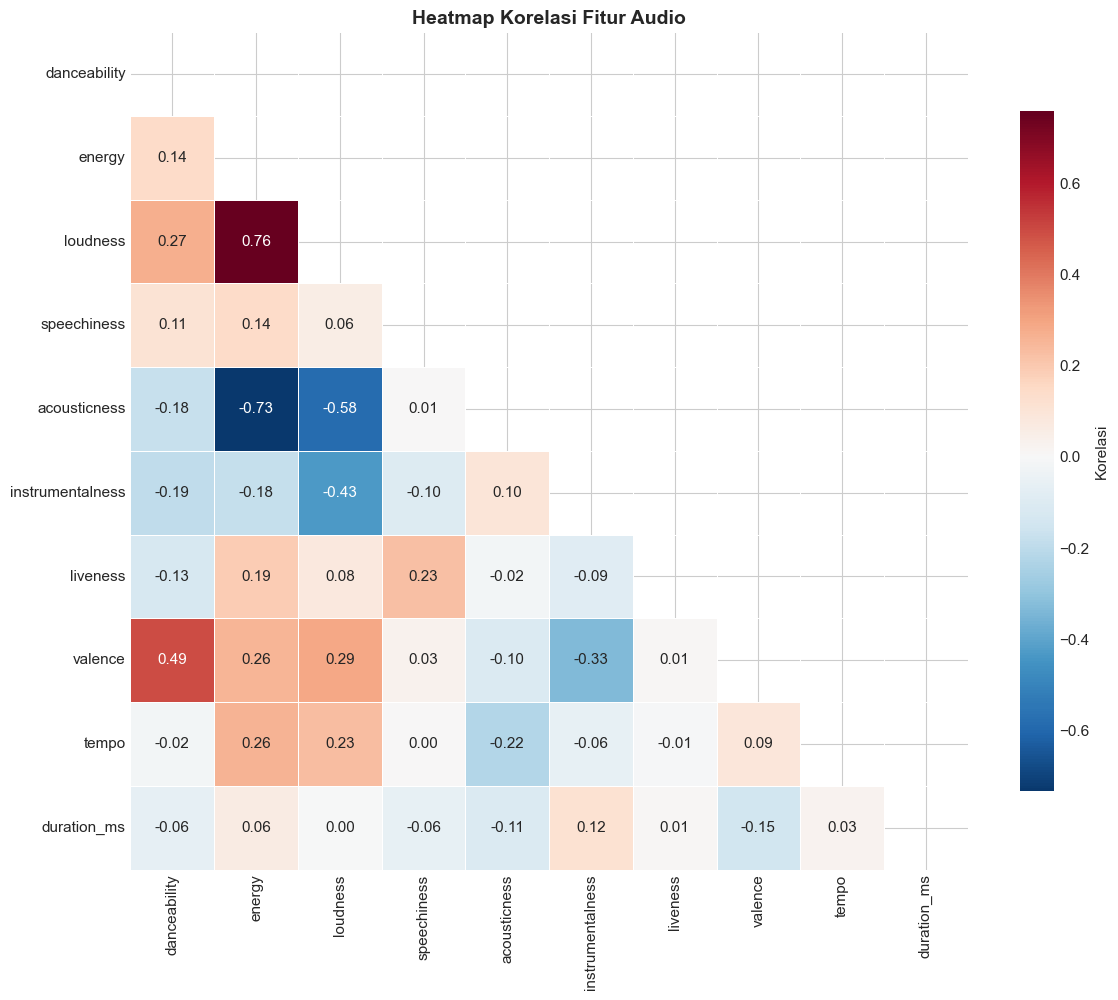


📊 KORELASI KUAT (|r| > 0.5):
----------------------------------------
   • energy vs loudness: 0.759
   • energy vs acousticness: -0.733
   • loudness vs acousticness: -0.583

💡 INSIGHT:
   • Energy ↔ Loudness: Korelasi positif kuat (lagu energik cenderung lebih keras)
   • Energy ↔ Acousticness: Korelasi negatif kuat (lagu akustik cenderung lebih tenang)
   • PCA akan membantu menangani multikolinearitas ini


In [70]:
# Heatmap Korelasi
corr_matrix = df[audio_features].corr()

fig, ax = plt.subplots(figsize=(12, 10))

# Mask untuk segitiga atas
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Heatmap
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            fmt='.2f', 
            cmap='RdBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.8, 'label': 'Korelasi'},
            ax=ax)

ax.set_title('Heatmap Korelasi Fitur Audio', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Identifikasi korelasi kuat
print("\n📊 KORELASI KUAT (|r| > 0.5):")
print("-" * 40)
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            print(f"   • {corr_matrix.columns[i]} vs {corr_matrix.columns[j]}: {corr_val:.3f}")

print("\n💡 INSIGHT:")
print("   • Energy ↔ Loudness: Korelasi positif kuat (lagu energik cenderung lebih keras)")
print("   • Energy ↔ Acousticness: Korelasi negatif kuat (lagu akustik cenderung lebih tenang)")
print("   • PCA akan membantu menangani multikolinearitas ini")

---

# Bagian 3: Data Preprocessing

Pada bagian ini, kita akan mempersiapkan data untuk modelling dengan:
1. Feature Selection - memilih fitur audio yang relevan
2. Log Transformation - mengatasi skewness
3. Standard Scaling - normalisasi data

## 3.1 Feature Selection

Kita akan memilih hanya fitur audio numerik yang relevan untuk clustering.

In [71]:
# Kolom yang akan di-drop (non-audio features)
drop_columns = ['Unnamed: 0', 'track_id', 'track_name', 'artists', 'album_name', 'explicit']

# Simpan kolom track_genre untuk validasi nanti
df_genre = df['track_genre'].copy()
print(f"✅ Kolom 'track_genre' disimpan untuk validasi ({len(df_genre):,} records)")

# Buat dataset untuk training (X)
# Identifikasi kolom yang ada di dataset
existing_drop_cols = [col for col in drop_columns if col in df.columns]
print(f"\n📌 Kolom yang akan di-drop: {existing_drop_cols}")

# Buat copy dan drop kolom non-audio
X = df.drop(columns=existing_drop_cols + ['track_genre'], errors='ignore')

print(f"\n📊 Fitur yang digunakan untuk clustering:")
print(f"   {list(X.columns)}")
print(f"\n📊 Shape data X: {X.shape}")

✅ Kolom 'track_genre' disimpan untuk validasi (89,741 records)

📌 Kolom yang akan di-drop: ['Unnamed: 0', 'track_id', 'track_name', 'artists', 'album_name', 'explicit']

📊 Fitur yang digunakan untuk clustering:
   ['popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

📊 Shape data X: (89741, 14)


## 3.2 Transformation & Scaling dengan PowerTransformer

Kita akan menggunakan **PowerTransformer (Yeo-Johnson)** yang secara otomatis:
1. Menormalkan distribusi data yang skewed
2. Melakukan scaling (mean=0, std=1)

> 💡 **Keunggulan Yeo-Johnson**: Dapat menangani nilai negatif (seperti loudness) dan positif sekaligus.

In [72]:
# Pilih hanya kolom numerik
X_numeric = X.select_dtypes(include=[np.number])

print("=" * 60)
print("ANALISIS SKEWNESS SEBELUM TRANSFORMASI")
print("=" * 60)

# Simpan data asli untuk perbandingan nanti
X_original = X_numeric.copy()

# Analisis skewness sebelum transformasi
skewness_before = {}
for col in X_numeric.columns:
    skew = X_numeric[col].skew()
    skewness_before[col] = skew
    status = "⚠️ SKEWED" if abs(skew) > 1 else "✅ OK"
    print(f"   {col}: {skew:.2f} {status}")

# Terapkan PowerTransformer (Yeo-Johnson)
print("\n" + "=" * 60)
print("MENERAPKAN POWER TRANSFORMER (YEO-JOHNSON)")
print("=" * 60)

power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
X_scaled = power_transformer.fit_transform(X_numeric)

# Konversi ke DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X_numeric.columns)

print("\n✅ PowerTransformer berhasil diterapkan!")
print("   • Method: Yeo-Johnson")
print("   • Standardize: True (mean=0, std=1)")

# Analisis skewness setelah transformasi
print("\n" + "=" * 60)
print("ANALISIS SKEWNESS SETELAH TRANSFORMASI")
print("=" * 60)

skewness_after = {}
for col in X_scaled_df.columns:
    skew_after = X_scaled_df[col].skew()
    skewness_after[col] = skew_after
    improvement = abs(skewness_before[col]) - abs(skew_after)
    status = "✅ NORMAL" if abs(skew_after) < 0.5 else "⚠️ STILL SKEWED"
    print(f"   {col}: {skew_after:.2f} {status} (improvement: {improvement:.2f})")

print("\n📊 Statistik setelah PowerTransformer:")
print(X_scaled_df.describe().round(3).T[['mean', 'std', 'min', 'max']])

ANALISIS SKEWNESS SEBELUM TRANSFORMASI
   popularity: 0.07 ✅ OK
   duration_ms: 11.07 ⚠️ SKEWED
   danceability: -0.40 ✅ OK
   energy: -0.56 ✅ OK
   key: -0.00 ✅ OK
   loudness: -1.96 ⚠️ SKEWED
   mode: -0.57 ✅ OK
   speechiness: 4.55 ⚠️ SKEWED
   acousticness: 0.66 ✅ OK
   instrumentalness: 1.56 ⚠️ SKEWED
   liveness: 2.06 ⚠️ SKEWED
   valence: 0.13 ✅ OK
   tempo: 0.18 ✅ OK
   time_signature: -4.00 ⚠️ SKEWED

MENERAPKAN POWER TRANSFORMER (YEO-JOHNSON)

✅ PowerTransformer berhasil diterapkan!
   • Method: Yeo-Johnson
   • Standardize: True (mean=0, std=1)

ANALISIS SKEWNESS SETELAH TRANSFORMASI
   popularity: -0.36 ✅ NORMAL (improvement: -0.29)
   duration_ms: 0.08 ✅ NORMAL (improvement: 10.99)
   danceability: -0.04 ✅ NORMAL (improvement: 0.35)
   energy: -0.17 ✅ NORMAL (improvement: 0.39)
   key: -0.24 ✅ NORMAL (improvement: -0.24)
   loudness: 0.15 ✅ NORMAL (improvement: 1.81)
   mode: -0.57 ⚠️ STILL SKEWED (improvement: 0.00)
   speechiness: 0.69 ⚠️ STILL SKEWED (improvement: 3.85)

## 3.3 Visualisasi Validasi: Before vs After Transformation

Untuk membuktikan bahwa PowerTransformer berhasil mengubah data yang skewed menjadi normal, kita akan membuat perbandingan visual.

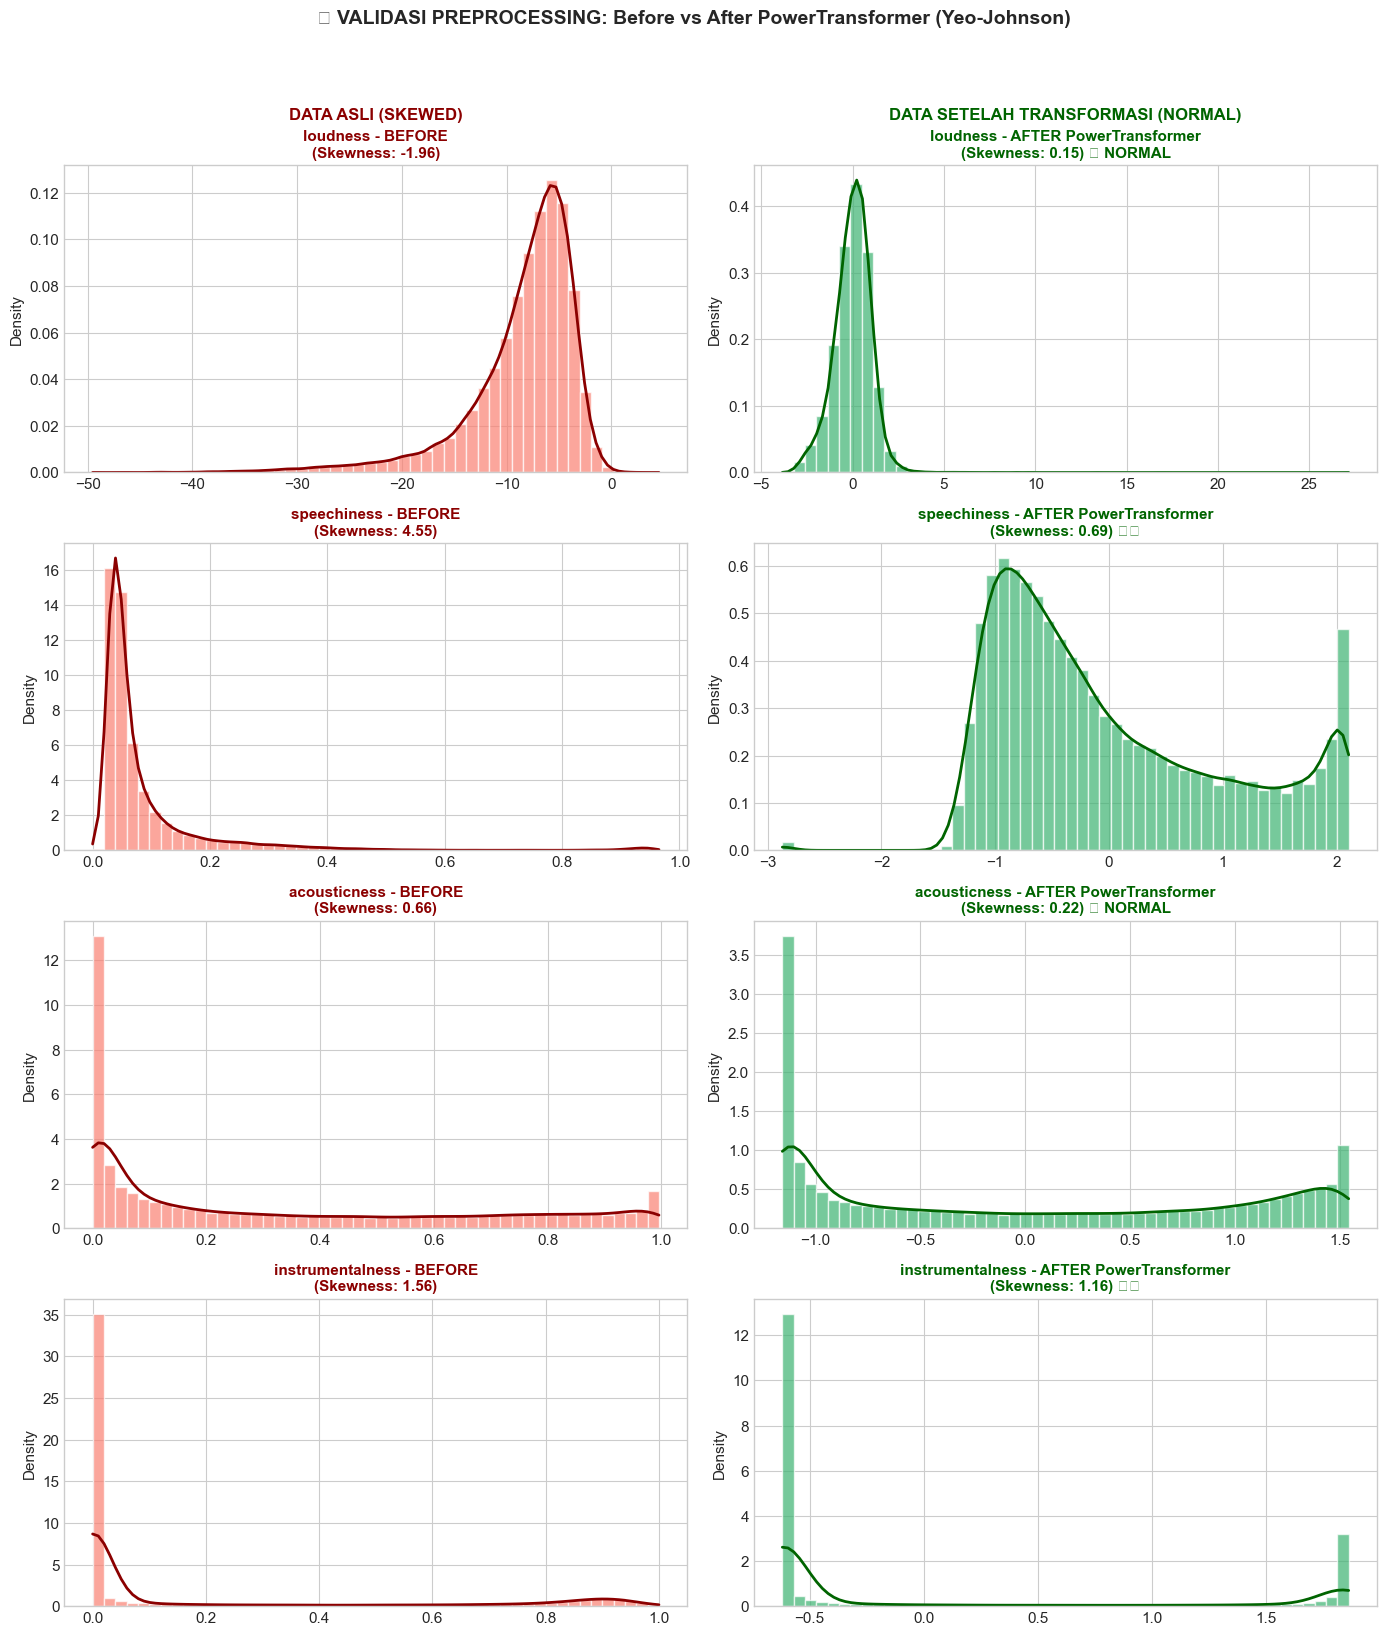


💡 INSIGHT:
   • Data yang tadinya 'miring' (skewed) sekarang berbentuk 'lonceng' (normal)
   • K-Means bekerja optimal dengan data yang terdistribusi normal
   • ✅ Data siap untuk proses clustering!


In [73]:
# Pilih 4 fitur yang biasanya skewed untuk perbandingan
comparison_features = ['loudness', 'speechiness', 'acousticness', 'instrumentalness']

# Pastikan fitur ada di dataset
comparison_features = [f for f in comparison_features if f in X_numeric.columns]

# Buat visualisasi Before vs After (4 baris x 2 kolom)
fig, axes = plt.subplots(len(comparison_features), 2, figsize=(14, 4*len(comparison_features)))

for i, feature in enumerate(comparison_features):
    # Kolom Kiri: Data Asli (Sebelum Transformasi)
    ax_before = axes[i, 0]
    data_before = X_original[feature].dropna()
    ax_before.hist(data_before, bins=50, color='salmon', alpha=0.7, edgecolor='white', density=True)
    
    # Tambahkan KDE
    from scipy import stats
    kde_x = np.linspace(data_before.min(), data_before.max(), 100)
    kde = stats.gaussian_kde(data_before)
    ax_before.plot(kde_x, kde(kde_x), color='darkred', linewidth=2)
    
    skew_before = data_before.skew()
    ax_before.set_title(f'{feature} - BEFORE\n(Skewness: {skew_before:.2f})', 
                        fontsize=11, fontweight='bold', color='darkred')
    ax_before.set_ylabel('Density')
    
    # Kolom Kanan: Data Setelah Transformasi
    ax_after = axes[i, 1]
    data_after = X_scaled_df[feature].dropna()
    ax_after.hist(data_after, bins=50, color='mediumseagreen', alpha=0.7, edgecolor='white', density=True)
    
    # Tambahkan KDE
    kde_x_after = np.linspace(data_after.min(), data_after.max(), 100)
    kde_after = stats.gaussian_kde(data_after)
    ax_after.plot(kde_x_after, kde_after(kde_x_after), color='darkgreen', linewidth=2)
    
    skew_after = data_after.skew()
    status = "✅ NORMAL" if abs(skew_after) < 0.5 else "⚠️"
    ax_after.set_title(f'{feature} - AFTER PowerTransformer\n(Skewness: {skew_after:.2f}) {status}', 
                       fontsize=11, fontweight='bold', color='darkgreen')
    ax_after.set_ylabel('Density')

# Tambahkan header
fig.suptitle('📊 VALIDASI PREPROCESSING: Before vs After PowerTransformer (Yeo-Johnson)\n', 
             fontsize=14, fontweight='bold', y=1.02)

# Tambahkan label kolom
axes[0, 0].annotate('DATA ASLI (SKEWED)', xy=(0.5, 1.15), xycoords='axes fraction',
                    ha='center', fontsize=12, fontweight='bold', color='darkred')
axes[0, 1].annotate('DATA SETELAH TRANSFORMASI (NORMAL)', xy=(0.5, 1.15), xycoords='axes fraction',
                    ha='center', fontsize=12, fontweight='bold', color='darkgreen')

plt.tight_layout()
plt.show()

print("\n💡 INSIGHT:")
print("   • Data yang tadinya 'miring' (skewed) sekarang berbentuk 'lonceng' (normal)")
print("   • K-Means bekerja optimal dengan data yang terdistribusi normal")
print("   • ✅ Data siap untuk proses clustering!")

---

# Bagian 4: Dimensionality Reduction (PCA)

Principal Component Analysis (PCA) akan membantu:
1. Mengurangi dimensi data sambil mempertahankan informasi penting
2. Mengatasi multikolinearitas antar fitur
3. Mempercepat proses clustering

## 4.1 Analisis Variance Explained

Kita akan menentukan jumlah komponen PCA yang optimal berdasarkan cumulative variance explained (target: minimal 80%).

ANALISIS PCA - VARIANCE EXPLAINED

📊 Jumlah fitur asli: 14
📊 Jumlah komponen untuk 80% variance: 9
📊 Variance explained dengan 9 komponen: 82.65%


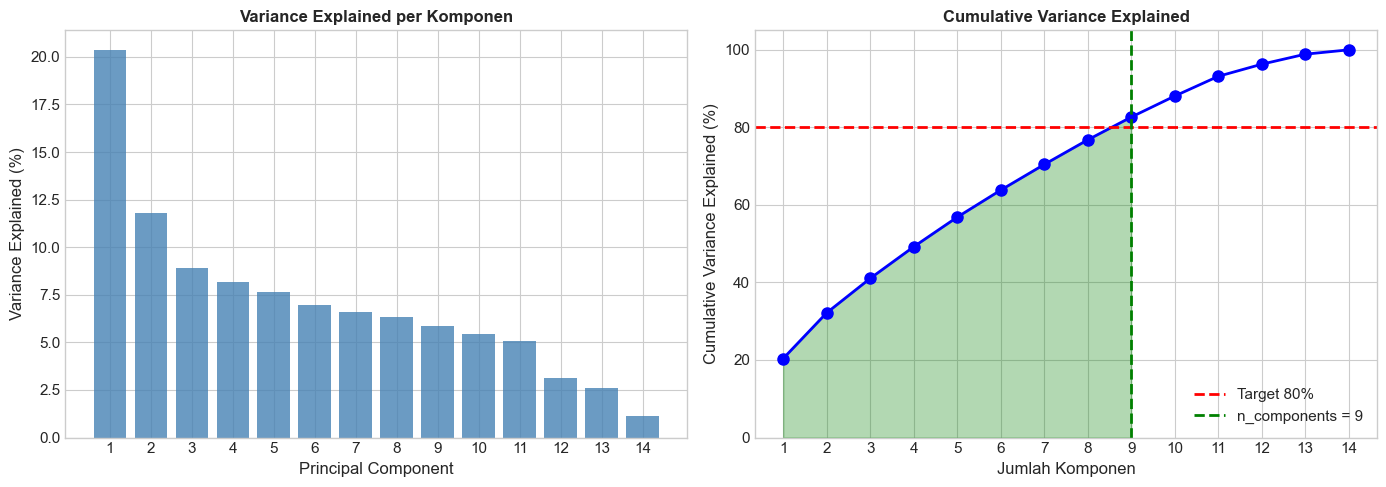

In [74]:
# PCA untuk semua komponen terlebih dahulu (untuk analisis)
pca_full = PCA()
pca_full.fit(X_scaled)

# Hitung cumulative variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Cari jumlah komponen untuk 80% variance
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1

print("=" * 60)
print("ANALISIS PCA - VARIANCE EXPLAINED")
print("=" * 60)
print(f"\n📊 Jumlah fitur asli: {X_scaled.shape[1]}")
print(f"📊 Jumlah komponen untuk 80% variance: {n_components_80}")
print(f"📊 Variance explained dengan {n_components_80} komponen: {cumulative_variance[n_components_80-1]*100:.2f}%")

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Individual variance
ax1 = axes[0]
ax1.bar(range(1, len(pca_full.explained_variance_ratio_)+1), 
        pca_full.explained_variance_ratio_ * 100, 
        color='steelblue', alpha=0.8)
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Variance Explained (%)', fontsize=12)
ax1.set_title('Variance Explained per Komponen', fontsize=12, fontweight='bold')
ax1.set_xticks(range(1, len(pca_full.explained_variance_ratio_)+1))

# Plot 2: Cumulative variance
ax2 = axes[1]
ax2.plot(range(1, len(cumulative_variance)+1), cumulative_variance * 100, 
         'bo-', linewidth=2, markersize=8)
ax2.axhline(y=80, color='red', linestyle='--', linewidth=2, label='Target 80%')
ax2.axvline(x=n_components_80, color='green', linestyle='--', linewidth=2, 
            label=f'n_components = {n_components_80}')
ax2.fill_between(range(1, n_components_80+1), 
                 cumulative_variance[:n_components_80] * 100, 
                 alpha=0.3, color='green')
ax2.set_xlabel('Jumlah Komponen', fontsize=12)
ax2.set_ylabel('Cumulative Variance Explained (%)', fontsize=12)
ax2.set_title('Cumulative Variance Explained', fontsize=12, fontweight='bold')
ax2.set_xticks(range(1, len(cumulative_variance)+1))
ax2.legend(loc='lower right')
ax2.set_ylim([0, 105])

plt.tight_layout()
plt.show()

## 4.2 Transformasi Data dengan PCA

Sekarang kita akan mentransformasi data menggunakan jumlah komponen yang sudah ditentukan.

In [75]:
# Terapkan PCA dengan jumlah komponen optimal
pca = PCA(n_components=n_components_80)
X_pca = pca.fit_transform(X_scaled)

print("=" * 60)
print("HASIL TRANSFORMASI PCA")
print("=" * 60)
print(f"\n📊 Shape data sebelum PCA: {X_scaled.shape}")
print(f"📊 Shape data setelah PCA: {X_pca.shape}")
print(f"📊 Reduksi dimensi: {X_scaled.shape[1]} → {X_pca.shape[1]} ({((X_scaled.shape[1] - X_pca.shape[1])/X_scaled.shape[1]*100):.1f}% reduction)")
print(f"📊 Total variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# Detail variance per komponen
print("\n📊 Variance Explained per Komponen:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"   PC{i+1}: {var*100:.2f}%")

HASIL TRANSFORMASI PCA

📊 Shape data sebelum PCA: (89741, 14)
📊 Shape data setelah PCA: (89741, 9)
📊 Reduksi dimensi: 14 → 9 (35.7% reduction)
📊 Total variance explained: 82.65%

📊 Variance Explained per Komponen:
   PC1: 20.37%
   PC2: 11.79%
   PC3: 8.88%
   PC4: 8.16%
   PC5: 7.64%
   PC6: 6.97%
   PC7: 6.62%
   PC8: 6.35%
   PC9: 5.87%


---

# Bagian 5: Modelling Strategy (Advanced - Composite Score)

Pada bagian ini, kita akan mencari jumlah cluster optimal (K) menggunakan pendekatan **Composite Score** yang menggabungkan 3 metrik evaluasi clustering:
1. **Silhouette Score** - mengukur seberapa mirip objek dengan cluster-nya sendiri vs cluster lain
2. **Calinski-Harabasz Index (CHI)** - rasio antara dispersi antar-cluster dan dispersi dalam-cluster
3. **Davies-Bouldin Index (DBI)** - rata-rata kemiripan cluster dengan cluster terdekatnya (makin kecil makin baik)

## 5.1 Sampling Data untuk Pencarian K Optimal

Karena dataset cukup besar (114K+ baris), kita akan menggunakan sample acak 20.000 data untuk mempercepat proses pencarian K optimal.

In [76]:
# Sampling untuk pencarian K optimal
np.random.seed(42)
sample_size = 20000

if len(X_pca) > sample_size:
    sample_indices = np.random.choice(len(X_pca), sample_size, replace=False)
    X_sample = X_pca[sample_indices]
else:
    X_sample = X_pca.copy()

print("=" * 60)
print("SAMPLING DATA")
print("=" * 60)
print(f"\n📊 Ukuran data asli: {len(X_pca):,}")
print(f"📊 Ukuran sample untuk pencarian K: {len(X_sample):,}")
print(f"📊 Persentase sample: {len(X_sample)/len(X_pca)*100:.1f}%")

SAMPLING DATA

📊 Ukuran data asli: 89,741
📊 Ukuran sample untuk pencarian K: 20,000
📊 Persentase sample: 22.3%


## 5.2 Evaluasi Metrik untuk Setiap K

Kita akan mengevaluasi K dalam range **4-10** sesuai business constraint (tidak terlalu sedikit, tidak terlalu banyak).

In [77]:
# Business Constraint: K range 4-10
k_range = range(4, 10)

# Dictionary untuk menyimpan metrik
metrics = {
    'k': [],
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': [],
    'inertia': []
}

print("=" * 60)
print("EVALUASI METRIK UNTUK SETIAP K")
print("=" * 60)
print("\nMemproses K-Means untuk setiap nilai K...")
print("-" * 60)

for k in k_range:
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_sample)
    
    # Hitung metrik
    sil = silhouette_score(X_sample, labels)
    chi = calinski_harabasz_score(X_sample, labels)
    dbi = davies_bouldin_score(X_sample, labels)
    inertia = kmeans.inertia_
    
    # Simpan metrik
    metrics['k'].append(k)
    metrics['silhouette'].append(sil)
    metrics['calinski_harabasz'].append(chi)
    metrics['davies_bouldin'].append(dbi)
    metrics['inertia'].append(inertia)
    
    print(f"   K={k:2d} | Silhouette: {sil:.4f} | CHI: {chi:,.0f} | DBI: {dbi:.4f}")

# Konversi ke DataFrame
metrics_df = pd.DataFrame(metrics)
print("\n✅ Evaluasi selesai!")

EVALUASI METRIK UNTUK SETIAP K

Memproses K-Means untuk setiap nilai K...
------------------------------------------------------------
   K= 4 | Silhouette: 0.1096 | CHI: 2,653 | DBI: 2.2795
   K= 4 | Silhouette: 0.1096 | CHI: 2,653 | DBI: 2.2795
   K= 5 | Silhouette: 0.1118 | CHI: 2,394 | DBI: 2.1518
   K= 5 | Silhouette: 0.1118 | CHI: 2,394 | DBI: 2.1518
   K= 6 | Silhouette: 0.1179 | CHI: 2,217 | DBI: 1.9427
   K= 6 | Silhouette: 0.1179 | CHI: 2,217 | DBI: 1.9427
   K= 7 | Silhouette: 0.1118 | CHI: 2,045 | DBI: 2.0507
   K= 7 | Silhouette: 0.1118 | CHI: 2,045 | DBI: 2.0507
   K= 8 | Silhouette: 0.1124 | CHI: 1,975 | DBI: 1.9357
   K= 8 | Silhouette: 0.1124 | CHI: 1,975 | DBI: 1.9357
   K= 9 | Silhouette: 0.1077 | CHI: 1,860 | DBI: 1.9412

✅ Evaluasi selesai!
   K= 9 | Silhouette: 0.1077 | CHI: 1,860 | DBI: 1.9412

✅ Evaluasi selesai!


## 5.3 Composite Score Calculation

Rumus Composite Score:
$$Score = \frac{Norm(Silhouette) + Norm(CHI) + (1 - Norm(DBI))}{3}$$

Dimana:
- $Norm()$ adalah MinMax Scaling ke range [0, 1]
- DBI dibalik karena **makin kecil makin bagus**

In [78]:
# Fungsi untuk MinMax Normalization
def minmax_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalisasi setiap metrik
metrics_df['sil_norm'] = minmax_normalize(metrics_df['silhouette'])
metrics_df['chi_norm'] = minmax_normalize(metrics_df['calinski_harabasz'])
metrics_df['dbi_norm'] = minmax_normalize(metrics_df['davies_bouldin'])

# Hitung Composite Score
# DBI dibalik (1 - norm) karena makin kecil makin bagus
metrics_df['composite_score'] = (
    metrics_df['sil_norm'] + 
    metrics_df['chi_norm'] + 
    (1 - metrics_df['dbi_norm'])
) / 3

# Tentukan K terbaik
best_k_idx = metrics_df['composite_score'].idxmax()
best_k = metrics_df.loc[best_k_idx, 'k']
best_score = metrics_df.loc[best_k_idx, 'composite_score']

print("=" * 60)
print("COMPOSITE SCORE CALCULATION")
print("=" * 60)
print("\n📊 Tabel Composite Score:")
print(metrics_df[['k', 'sil_norm', 'chi_norm', 'dbi_norm', 'composite_score']].round(4).to_string(index=False))
print("\n" + "=" * 60)
print(f"🎯 K OPTIMAL = {int(best_k)} dengan Composite Score = {best_score:.4f}")
print("=" * 60)

COMPOSITE SCORE CALCULATION

📊 Tabel Composite Score:
 k  sil_norm  chi_norm  dbi_norm  composite_score
 4    0.1853    1.0000    1.0000           0.3951
 5    0.3985    0.6735    0.6284           0.4812
 6    1.0000    0.4499    0.0202           0.8099
 7    0.4002    0.2328    0.3344           0.4329
 8    0.4643    0.1454    0.0000           0.5366
 9    0.0000    0.0000    0.0159           0.3280

🎯 K OPTIMAL = 6 dengan Composite Score = 0.8099


## 5.4 Visualisasi Metrik dan Composite Score

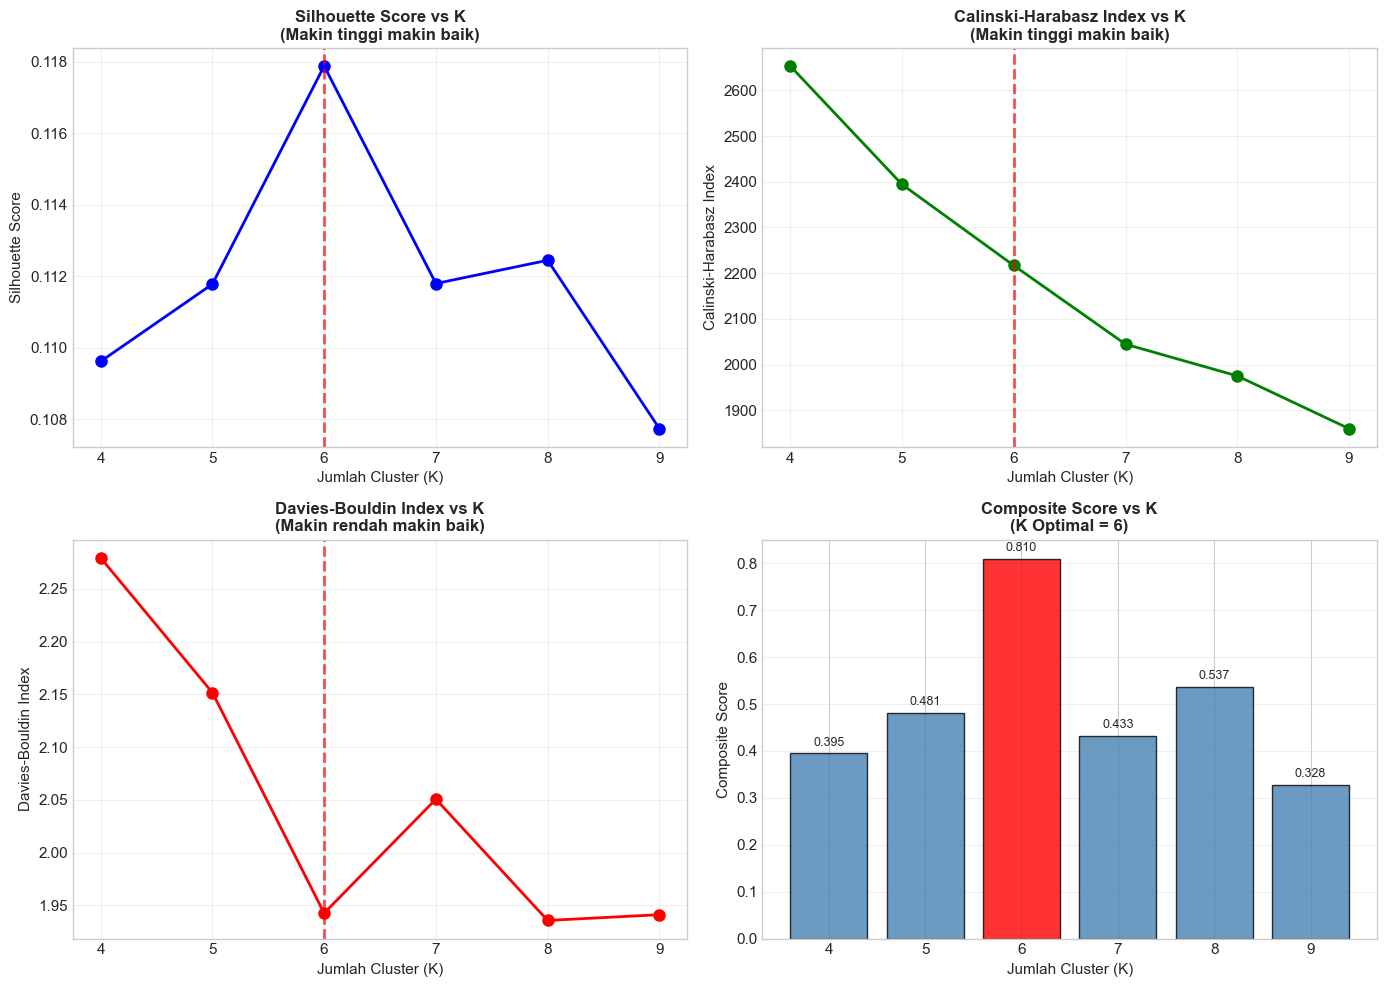

In [79]:
# Visualisasi Metrik
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Silhouette Score
ax1 = axes[0, 0]
ax1.plot(metrics_df['k'], metrics_df['silhouette'], 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=best_k, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax1.set_xlabel('Jumlah Cluster (K)', fontsize=11)
ax1.set_ylabel('Silhouette Score', fontsize=11)
ax1.set_title('Silhouette Score vs K\n(Makin tinggi makin baik)', fontsize=12, fontweight='bold')
ax1.set_xticks(metrics_df['k'])
ax1.grid(True, alpha=0.3)

# Plot 2: Calinski-Harabasz Index
ax2 = axes[0, 1]
ax2.plot(metrics_df['k'], metrics_df['calinski_harabasz'], 'go-', linewidth=2, markersize=8)
ax2.axvline(x=best_k, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.set_xlabel('Jumlah Cluster (K)', fontsize=11)
ax2.set_ylabel('Calinski-Harabasz Index', fontsize=11)
ax2.set_title('Calinski-Harabasz Index vs K\n(Makin tinggi makin baik)', fontsize=12, fontweight='bold')
ax2.set_xticks(metrics_df['k'])
ax2.grid(True, alpha=0.3)

# Plot 3: Davies-Bouldin Index
ax3 = axes[1, 0]
ax3.plot(metrics_df['k'], metrics_df['davies_bouldin'], 'ro-', linewidth=2, markersize=8)
ax3.axvline(x=best_k, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax3.set_xlabel('Jumlah Cluster (K)', fontsize=11)
ax3.set_ylabel('Davies-Bouldin Index', fontsize=11)
ax3.set_title('Davies-Bouldin Index vs K\n(Makin rendah makin baik)', fontsize=12, fontweight='bold')
ax3.set_xticks(metrics_df['k'])
ax3.grid(True, alpha=0.3)

# Plot 4: Composite Score (HIGHLIGHT)
ax4 = axes[1, 1]
colors = ['red' if k == best_k else 'steelblue' for k in metrics_df['k']]
bars = ax4.bar(metrics_df['k'], metrics_df['composite_score'], color=colors, edgecolor='black', alpha=0.8)
ax4.set_xlabel('Jumlah Cluster (K)', fontsize=11)
ax4.set_ylabel('Composite Score', fontsize=11)
ax4.set_title(f'Composite Score vs K\n(K Optimal = {int(best_k)})', fontsize=12, fontweight='bold')
ax4.set_xticks(metrics_df['k'])
ax4.grid(True, alpha=0.3, axis='y')

# Tambahkan label nilai di atas bar
for bar, score in zip(bars, metrics_df['composite_score']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

---

# Bagian 6: Final Clustering & Profiling

Sekarang kita akan melatih K-Means dengan K optimal pada **FULL DATASET** dan membuat profil karakteristik setiap cluster.

## 6.1 Training K-Means pada Full Dataset

In [80]:
# Training K-Means dengan K optimal pada FULL DATASET
optimal_k = int(best_k)

print("=" * 60)
print(f"TRAINING K-MEANS DENGAN K = {optimal_k} PADA FULL DATASET")
print("=" * 60)

# Fit K-Means
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
cluster_labels = kmeans_final.fit_predict(X_pca)

# Tambahkan label cluster ke dataframe asli
df['cluster'] = cluster_labels

print(f"\n✅ K-Means berhasil dilatih!")
print(f"📊 Jumlah data: {len(X_pca):,}")
print(f"📊 Jumlah cluster: {optimal_k}")

# Distribusi cluster
print("\n📊 Distribusi Lagu per Cluster:")
print("-" * 40)
cluster_dist = df['cluster'].value_counts().sort_index()
for cluster, count in cluster_dist.items():
    pct = count / len(df) * 100
    print(f"   Cluster {cluster}: {count:,} lagu ({pct:.1f}%)")

TRAINING K-MEANS DENGAN K = 6 PADA FULL DATASET

✅ K-Means berhasil dilatih!
📊 Jumlah data: 89,741
📊 Jumlah cluster: 6

📊 Distribusi Lagu per Cluster:
----------------------------------------
   Cluster 0: 9,339 lagu (10.4%)
   Cluster 1: 18,537 lagu (20.7%)
   Cluster 2: 15,359 lagu (17.1%)
   Cluster 3: 11,043 lagu (12.3%)
   Cluster 4: 19,854 lagu (22.1%)
   Cluster 5: 15,609 lagu (17.4%)

✅ K-Means berhasil dilatih!
📊 Jumlah data: 89,741
📊 Jumlah cluster: 6

📊 Distribusi Lagu per Cluster:
----------------------------------------
   Cluster 0: 9,339 lagu (10.4%)
   Cluster 1: 18,537 lagu (20.7%)
   Cluster 2: 15,359 lagu (17.1%)
   Cluster 3: 11,043 lagu (12.3%)
   Cluster 4: 19,854 lagu (22.1%)
   Cluster 5: 15,609 lagu (17.4%)


## 6.2 Profil Cluster - Radar Chart

Radar Chart akan membantu kita memvisualisasikan karakteristik rata-rata fitur audio untuk setiap cluster.

In [81]:
# Fitur audio untuk radar chart (pilih fitur yang relevan dan terukur 0-1)
radar_features = ['danceability', 'energy', 'speechiness', 'acousticness', 
                  'instrumentalness', 'liveness', 'valence']

# Hitung rata-rata per cluster
cluster_means = df.groupby('cluster')[radar_features].mean()

# Normalisasi ke 0-1 untuk radar chart yang proporsional
scaler_minmax = MinMaxScaler()
cluster_means_normalized = pd.DataFrame(
    scaler_minmax.fit_transform(cluster_means),
    columns=radar_features,
    index=cluster_means.index
)

print("📊 Rata-rata Fitur per Cluster (Normalized 0-1):")
print(cluster_means_normalized.round(3))

📊 Rata-rata Fitur per Cluster (Normalized 0-1):
         danceability  energy  speechiness  acousticness  instrumentalness  \
cluster                                                                      
0               0.000   0.000        0.000         1.000             1.000   
1               1.000   0.748        0.555         0.217             0.012   
2               0.996   0.709        1.000         0.263             0.021   
3               0.624   0.803        0.095         0.000             0.834   
4               0.481   0.318        0.003         0.728             0.000   
5               0.257   1.000        0.950         0.012             0.127   

         liveness  valence  
cluster                     
0           0.144    0.000  
1           0.121    1.000  
2           0.311    0.865  
3           0.000    0.247  
4           0.375    0.477  
5           1.000    0.420  


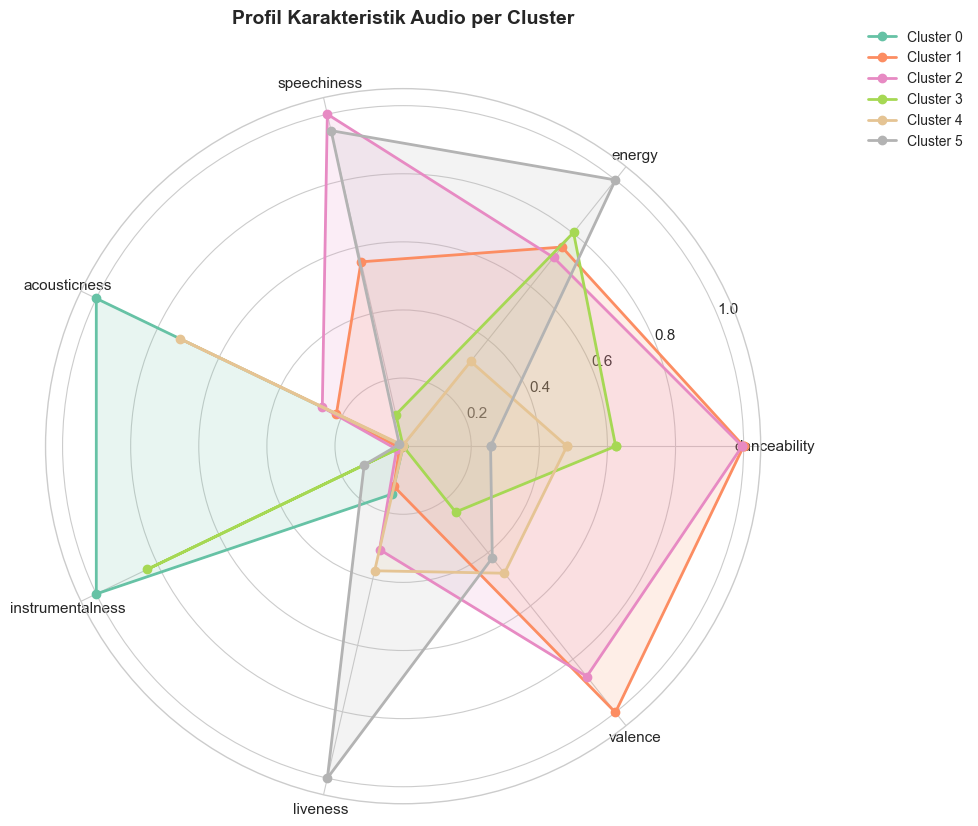

In [82]:
# Buat Radar Chart
def create_radar_chart(cluster_data, features, title):
    """Membuat radar chart untuk profil cluster"""
    
    # Jumlah variabel
    num_vars = len(features)
    
    # Sudut untuk setiap sumbu
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Tutup lingkaran
    
    # Warna untuk setiap cluster
    colors = plt.cm.Set2(np.linspace(0, 1, len(cluster_data)))
    
    # Buat figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Plot setiap cluster
    for idx, (cluster, row) in enumerate(cluster_data.iterrows()):
        values = row.values.flatten().tolist()
        values += values[:1]  # Tutup lingkaran
        
        ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster}', 
                color=colors[idx], markersize=6)
        ax.fill(angles, values, alpha=0.15, color=colors[idx])
    
    # Set label
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=11)
    
    # Set judul dan legend
    ax.set_title(title, fontsize=14, fontweight='bold', y=1.08)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
    
    plt.tight_layout()
    return fig

# Buat radar chart
fig = create_radar_chart(cluster_means_normalized, radar_features, 
                         'Profil Karakteristik Audio per Cluster')
plt.show()

## 6.3 Interpretasi Karakteristik Cluster

Berdasarkan radar chart dan analisis data, berikut interpretasi setiap cluster:

In [83]:
# Interpretasi otomatis berdasarkan fitur dominan
def interpret_cluster(cluster_id, cluster_row):
    """Menginterpretasi karakteristik cluster berdasarkan fitur dominan"""
    
    interpretations = []
    
    # Energy & Danceability tinggi
    if cluster_row['energy'] > 0.7 and cluster_row['danceability'] > 0.6:
        interpretations.append("🎉 High Energy / Party Music")
    
    # Acousticness tinggi
    if cluster_row['acousticness'] > 0.7:
        interpretations.append("🎸 Acoustic / Unplugged")
    
    # Instrumentalness tinggi
    if cluster_row['instrumentalness'] > 0.7:
        interpretations.append("🎻 Instrumental / Ambient")
    
    # Valence tinggi = positif/ceria
    if cluster_row['valence'] > 0.7:
        interpretations.append("😊 Happy / Upbeat")
    elif cluster_row['valence'] < 0.3:
        interpretations.append("😔 Melancholic / Sad")
    
    # Speechiness tinggi
    if cluster_row['speechiness'] > 0.7:
        interpretations.append("🎤 Vocal-heavy / Spoken Word")
    
    # Liveness tinggi
    if cluster_row['liveness'] > 0.7:
        interpretations.append("🎪 Live Performance Feel")
    
    # Default jika tidak ada karakteristik dominan
    if not interpretations:
        interpretations.append("🎵 Balanced / Mainstream")
    
    return interpretations

# Tampilkan interpretasi untuk setiap cluster
print("=" * 60)
print("INTERPRETASI KARAKTERISTIK CLUSTER")
print("=" * 60)

for cluster_id, row in cluster_means_normalized.iterrows():
    interpretations = interpret_cluster(cluster_id, row)
    count = df[df['cluster'] == cluster_id].shape[0]
    
    print(f"\n🔹 CLUSTER {cluster_id} ({count:,} lagu)")
    print("-" * 40)
    for interp in interpretations:
        print(f"   {interp}")
    
    # Tampilkan 3 fitur tertinggi
    top_features = row.nlargest(3)
    print(f"\n   Top Features: ", end="")
    print(", ".join([f"{feat}={val:.2f}" for feat, val in top_features.items()]))

INTERPRETASI KARAKTERISTIK CLUSTER

🔹 CLUSTER 0 (9,339 lagu)
----------------------------------------
   🎸 Acoustic / Unplugged
   🎻 Instrumental / Ambient
   😔 Melancholic / Sad

   Top Features: instrumentalness=1.00, acousticness=1.00, liveness=0.14

🔹 CLUSTER 1 (18,537 lagu)
----------------------------------------
   🎉 High Energy / Party Music
   😊 Happy / Upbeat

   Top Features: danceability=1.00, valence=1.00, energy=0.75

🔹 CLUSTER 2 (15,359 lagu)
----------------------------------------
   🎉 High Energy / Party Music
   😊 Happy / Upbeat
   🎤 Vocal-heavy / Spoken Word

   Top Features: speechiness=1.00, danceability=1.00, valence=0.87

🔹 CLUSTER 3 (11,043 lagu)
----------------------------------------
   🎉 High Energy / Party Music
   🎻 Instrumental / Ambient
   😔 Melancholic / Sad

   Top Features: instrumentalness=0.83, energy=0.80, danceability=0.62

🔹 CLUSTER 4 (19,854 lagu)
----------------------------------------
   🎸 Acoustic / Unplugged

   Top Features: acousticness=

## 6.4 Visualisasi Cluster dengan PCA

**PCA (Principal Component Analysis)** memberikan visualisasi linear dari hasil clustering. Meskipun tidak sedetail t-SNE, PCA memiliki keunggulan:
- Cepat dan efisien untuk dataset besar
- Deterministik (hasil selalu sama dengan seed yang sama)
- Komponen utama memiliki interpretasi varians yang jelas

VISUALISASI CLUSTER DENGAN PCA 2D

📊 Menggunakan sample 20,000 data untuk visualisasi PCA 2D


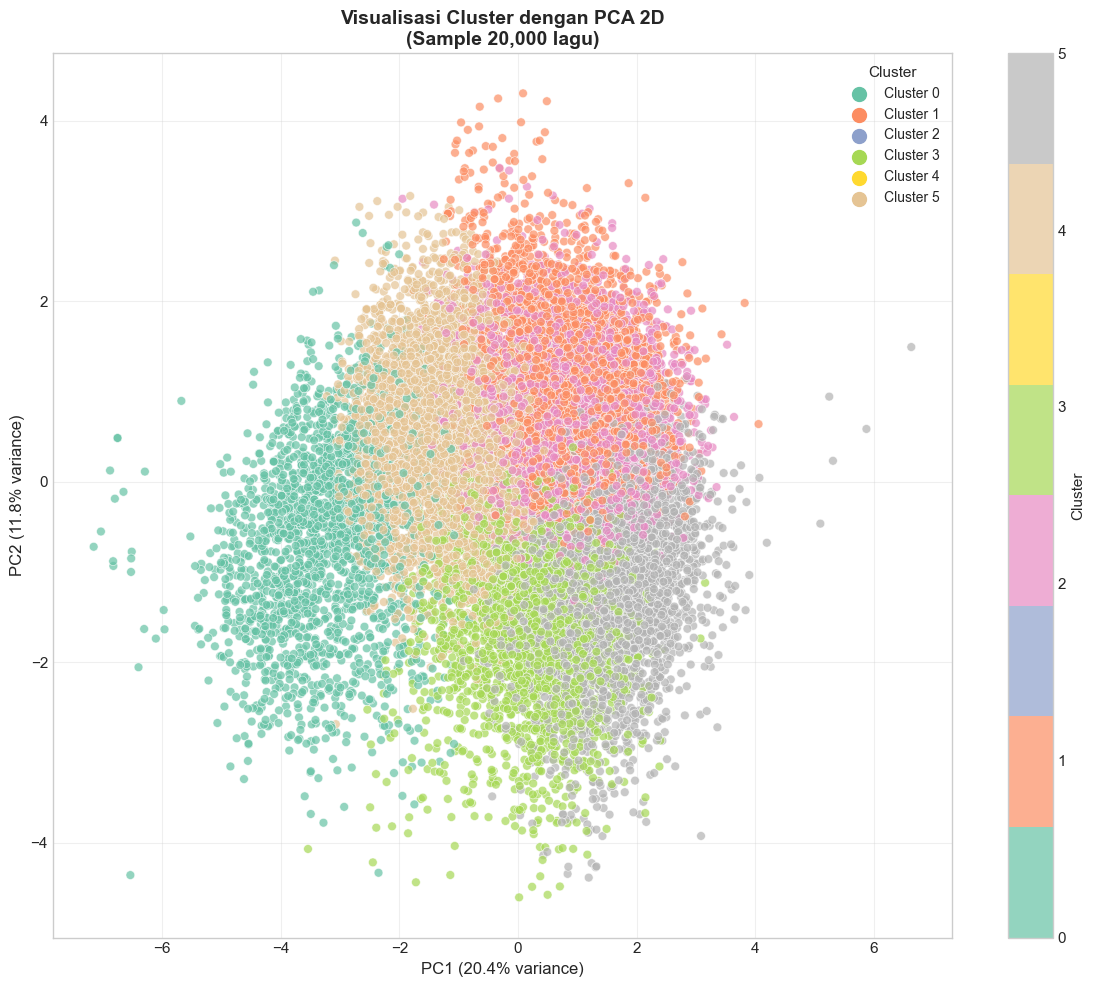


💡 INSIGHT:
   • PC1 menjelaskan 20.4% variance
   • PC2 menjelaskan 11.8% variance
   • PCA menggunakan proyeksi linear - cluster mungkin terlihat overlap


In [84]:
# Visualisasi PCA 2D
print("=" * 60)
print("VISUALISASI CLUSTER DENGAN PCA 2D")
print("=" * 60)

# Ambil sample untuk visualisasi (sama dengan t-SNE untuk konsistensi)
np.random.seed(42)
sample_size_pca = 20000

if len(X_pca) > sample_size_pca:
    sample_idx_pca = np.random.choice(len(X_pca), sample_size_pca, replace=False)
    X_pca_sample_2d = X_pca[sample_idx_pca]
    labels_pca_sample = cluster_labels[sample_idx_pca]
else:
    X_pca_sample_2d = X_pca
    labels_pca_sample = cluster_labels

print(f"\n📊 Menggunakan sample {len(X_pca_sample_2d):,} data untuk visualisasi PCA 2D")

# Visualisasi menggunakan 2 komponen utama pertama (PC1 vs PC2)
fig, ax = plt.subplots(figsize=(12, 10))

# Scatter plot dengan warna berdasarkan cluster
scatter = ax.scatter(X_pca_sample_2d[:, 0], X_pca_sample_2d[:, 1], 
                     c=labels_pca_sample, cmap='Set2', alpha=0.7, s=40, 
                     edgecolor='white', linewidth=0.5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title(f'Visualisasi Cluster dengan PCA 2D\n(Sample {sample_size_pca:,} lagu)', 
             fontsize=14, fontweight='bold')

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, ticks=range(optimal_k))
cbar.set_label('Cluster', fontsize=11)

# Tambahkan legend
handles = [plt.scatter([], [], c=plt.cm.Set2(i/optimal_k), s=100, label=f'Cluster {i}') 
           for i in range(optimal_k)]
ax.legend(handles=handles, title='Cluster', loc='upper right', fontsize=10)

# Tambahkan grid untuk kemudahan membaca
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 INSIGHT:")
print(f"   • PC1 menjelaskan {pca.explained_variance_ratio_[0]*100:.1f}% variance")
print(f"   • PC2 menjelaskan {pca.explained_variance_ratio_[1]*100:.1f}% variance")
print(f"   • PCA menggunakan proyeksi linear - cluster mungkin terlihat overlap")

### 6.4.1 Visualisasi Cluster dengan PCA 3D

Visualisasi 3D dengan PCA menggunakan 3 komponen utama pertama untuk memberikan perspektif spasial yang lebih kaya.

In [85]:
# Import plotly untuk visualisasi 3D interaktif
import plotly.express as px

print("=" * 60)
print("VISUALISASI CLUSTER DENGAN PCA 3D")
print("=" * 60)

# Gunakan sample yang sama
print(f"\n📊 Menggunakan sample {len(X_pca_sample_2d):,} data untuk visualisasi PCA 3D")

# Buat DataFrame untuk Plotly (gunakan 3 komponen pertama)
pca_3d_df = pd.DataFrame({
    'PC1': X_pca_sample_2d[:, 0],
    'PC2': X_pca_sample_2d[:, 1],
    'PC3': X_pca_sample_2d[:, 2] if X_pca_sample_2d.shape[1] >= 3 else np.zeros(len(X_pca_sample_2d)),
    'Cluster': labels_pca_sample.astype(str)
})

# Hitung variance explained untuk 3 komponen pertama
var_pc1 = pca.explained_variance_ratio_[0] * 100
var_pc2 = pca.explained_variance_ratio_[1] * 100
var_pc3 = pca.explained_variance_ratio_[2] * 100 if len(pca.explained_variance_ratio_) >= 3 else 0

# Visualisasi 3D dengan Plotly
fig = px.scatter_3d(
    pca_3d_df, 
    x='PC1', 
    y='PC2', 
    z='PC3',
    color='Cluster',
    title=f'Visualisasi Cluster 3D dengan PCA<br><sub>(Sample {sample_size_pca:,} lagu | PC1={var_pc1:.1f}%, PC2={var_pc2:.1f}%, PC3={var_pc3:.1f}%)</sub>',
    color_discrete_sequence=px.colors.qualitative.Set2,
    opacity=0.7,
    height=700
)

# Update layout
fig.update_layout(
    scene=dict(
        xaxis_title=f'PC1 ({var_pc1:.1f}% variance)',
        yaxis_title=f'PC2 ({var_pc2:.1f}% variance)',
        zaxis_title=f'PC3 ({var_pc3:.1f}% variance)',
        bgcolor='white'
    ),
    legend_title_text='Cluster',
    font=dict(size=12)
)

# Update marker size
fig.update_traces(marker=dict(size=4))

fig.show()

print(f"\n💡 INSIGHT:")
print(f"   • Total variance dijelaskan oleh PC1+PC2+PC3: {var_pc1+var_pc2+var_pc3:.1f}%")
print(f"   • PCA 3D memberikan visualisasi linear yang deterministik")
print(f"   • Cluster yang overlap menunjukkan karakteristik audio yang mirip")
print(f"   • Gunakan mouse untuk memutar dan zoom visualisasi interaktif")

VISUALISASI CLUSTER DENGAN PCA 3D

📊 Menggunakan sample 20,000 data untuk visualisasi PCA 3D



💡 INSIGHT:
   • Total variance dijelaskan oleh PC1+PC2+PC3: 41.0%
   • PCA 3D memberikan visualisasi linear yang deterministik
   • Cluster yang overlap menunjukkan karakteristik audio yang mirip
   • Gunakan mouse untuk memutar dan zoom visualisasi interaktif


## 6.6 Validasi Eksternal: Cluster vs Genre Asli

Kita akan membandingkan hasil clustering dengan label genre asli untuk melihat apakah cluster yang terbentuk memiliki korelasi dengan genre musik.

In [86]:
# Tambahkan kolom genre ke dataframe (gunakan df_genre yang sudah disimpan)
df['track_genre'] = df_genre.values

# Buat crosstab cluster vs genre
crosstab = pd.crosstab(df['cluster'], df['track_genre'], normalize='index') * 100

# Ambil top 15 genre berdasarkan jumlah lagu
top_genres = df['track_genre'].value_counts().head(15).index.tolist()
crosstab_top = crosstab[top_genres]

print("=" * 60)
print("CROSSTAB: CLUSTER VS TOP 15 GENRE (%)")
print("=" * 60)
print("\n(Persentase dalam baris - setiap baris = 100%)\n")
print(crosstab_top.round(1))

CROSSTAB: CLUSTER VS TOP 15 GENRE (%)

(Persentase dalam baris - setiap baris = 100%)

track_genre  acoustic  afrobeat  alt-rock  ambient  cantopop  tango  \
cluster                                                               
0                 0.7       0.2       0.1      8.0       0.3    1.5   
1                 0.9       1.7       1.3      0.0       0.4    0.4   
2                 0.3       2.3       1.3      0.0       0.3    1.1   
3                 0.2       1.5       1.2      0.7       0.1    0.0   
4                 3.3       0.5       0.7      0.8       4.0    3.1   
5                 0.3       0.3       1.7      0.1       0.2    0.0   

track_genre  chicago-house  forro  bluegrass  study  disney  breakbeat  \
cluster                                                                  
0                      0.0    0.0        0.6    5.4     5.6        0.0   
1                      0.9    2.4        1.1    0.7     0.6        0.7   
2                      0.9    2.0        0.4    

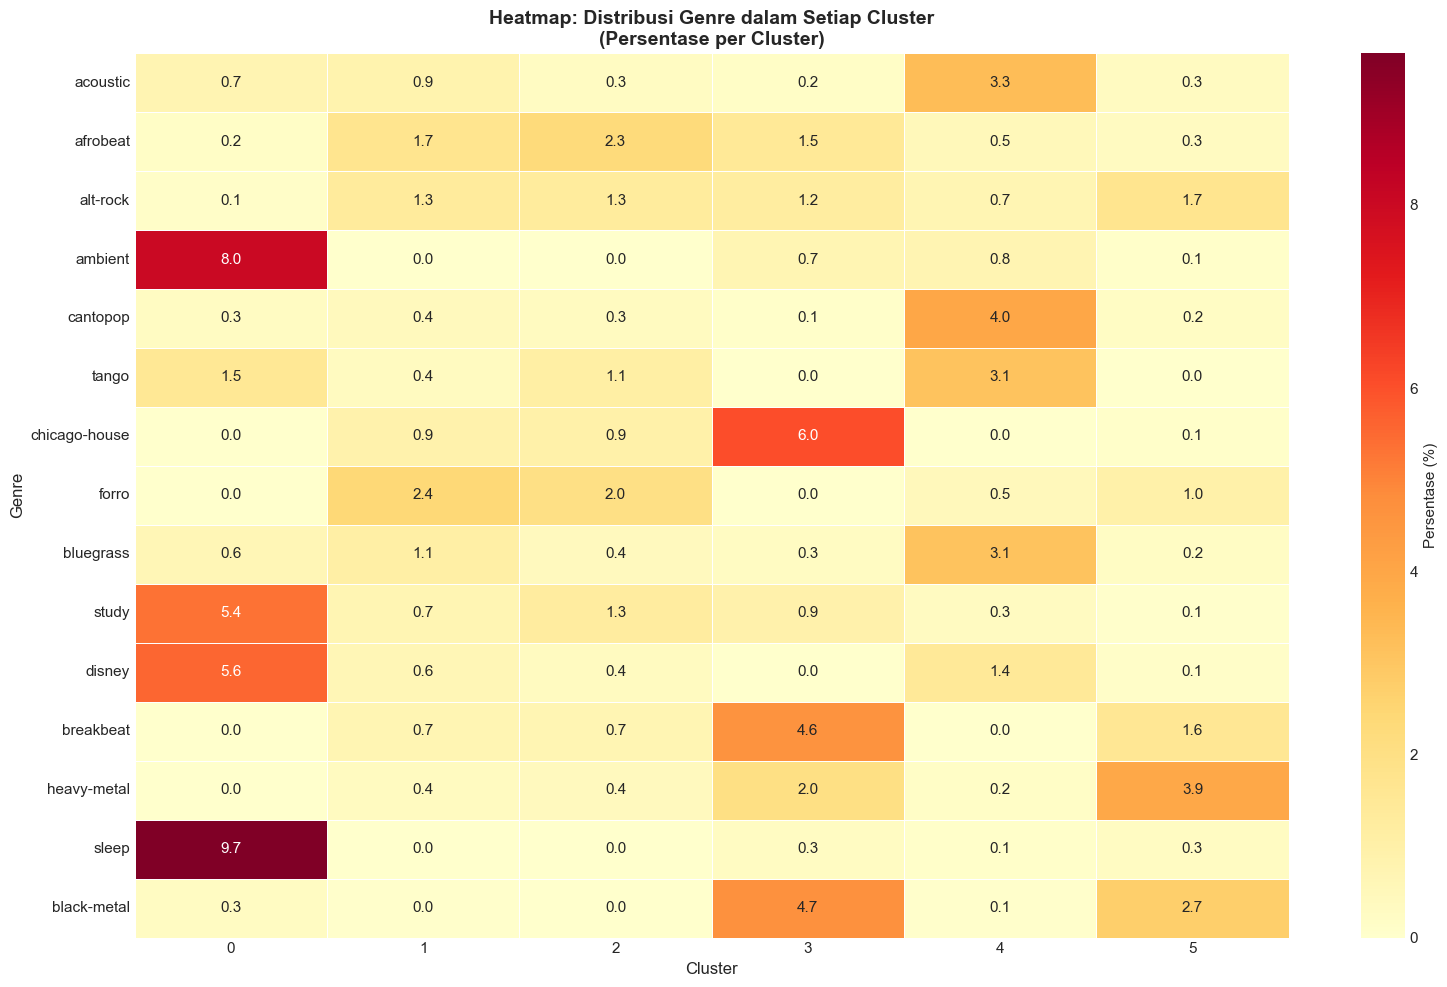


💡 INSIGHT:
   • Cluster dengan konsentrasi genre tertentu yang tinggi menunjukkan keberhasilan segmentasi
   • Jika genre tersebar merata di semua cluster, berarti karakteristik audio lebih dominan daripada label genre


In [87]:
# Visualisasi Heatmap Cluster vs Genre
fig, ax = plt.subplots(figsize=(16, 10))

sns.heatmap(crosstab_top.T, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Persentase (%)'}, ax=ax, linewidths=0.5)

ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Genre', fontsize=12)
ax.set_title('Heatmap: Distribusi Genre dalam Setiap Cluster\n(Persentase per Cluster)', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 INSIGHT:")
print("   • Cluster dengan konsentrasi genre tertentu yang tinggi menunjukkan keberhasilan segmentasi")
print("   • Jika genre tersebar merata di semua cluster, berarti karakteristik audio lebih dominan daripada label genre")

In [88]:
# Tampilkan genre dominan per cluster
print("=" * 60)
print("GENRE DOMINAN PER CLUSTER")
print("=" * 60)

for cluster_id in range(optimal_k):
    cluster_genres = crosstab.loc[cluster_id].sort_values(ascending=False)
    top_3_genres = cluster_genres.head(3)
    
    print(f"\n🔹 CLUSTER {cluster_id}:")
    for genre, pct in top_3_genres.items():
        print(f"   • {genre}: {pct:.1f}%")

GENRE DOMINAN PER CLUSTER

🔹 CLUSTER 0:
   • sleep: 9.7%
   • new-age: 8.7%
   • ambient: 8.0%

🔹 CLUSTER 1:
   • kids: 3.4%
   • children: 2.8%
   • salsa: 2.6%

🔹 CLUSTER 2:
   • dancehall: 3.1%
   • hip-hop: 2.6%
   • turkish: 2.5%

🔹 CLUSTER 3:
   • minimal-techno: 7.0%
   • detroit-techno: 6.9%
   • chicago-house: 6.0%

🔹 CLUSTER 4:
   • cantopop: 4.0%
   • honky-tonk: 4.0%
   • acoustic: 3.3%

🔹 CLUSTER 5:
   • grindcore: 4.8%
   • heavy-metal: 3.9%
   • death-metal: 3.8%


---

# Bagian 7: Kesimpulan

## 📊 Ringkasan Hasil Analisis

Proyek **Segmentasi Musik Spotify Berbasis Audio Features Menggunakan K-Means Clustering** telah berhasil dilakukan dengan hasil sebagai berikut:

In [89]:
# Ringkasan Final
print("=" * 70)
print("                    📊 RINGKASAN HASIL ANALISIS")
print("=" * 70)

print(f"""
📁 DATASET:
   • Total lagu setelah cleaning: {len(df):,} lagu
   • Jumlah genre unik: {df['track_genre'].nunique()} genre
   • Fitur audio yang digunakan: {len(X_numeric.columns)} fitur

🔧 PREPROCESSING:
   • Transformation: PowerTransformer (Yeo-Johnson)
   • Scaling: Standardized (mean=0, std=1)
   • PCA: {n_components_80} komponen ({sum(pca.explained_variance_ratio_)*100:.1f}% variance explained)
   • Visualisasi Cluster: t-SNE (perplexity=30)

🎯 HASIL CLUSTERING:
   • Algoritma: K-Means
   • Jumlah Cluster Optimal (K): {optimal_k}
   • Metode Pemilihan K: Composite Score (Silhouette + CHI + (1-DBI))
   • Composite Score Terbaik: {best_score:.4f}

📈 METRIK EVALUASI (K = {optimal_k}):
   • Silhouette Score: {metrics_df[metrics_df['k']==optimal_k]['silhouette'].values[0]:.4f}
   • Calinski-Harabasz Index: {metrics_df[metrics_df['k']==optimal_k]['calinski_harabasz'].values[0]:,.0f}
   • Davies-Bouldin Index: {metrics_df[metrics_df['k']==optimal_k]['davies_bouldin'].values[0]:.4f}
""")

print("=" * 70)

                    📊 RINGKASAN HASIL ANALISIS

📁 DATASET:
   • Total lagu setelah cleaning: 89,741 lagu
   • Jumlah genre unik: 113 genre
   • Fitur audio yang digunakan: 14 fitur

🔧 PREPROCESSING:
   • Transformation: PowerTransformer (Yeo-Johnson)
   • Scaling: Standardized (mean=0, std=1)
   • PCA: 9 komponen (82.6% variance explained)
   • Visualisasi Cluster: t-SNE (perplexity=30)

🎯 HASIL CLUSTERING:
   • Algoritma: K-Means
   • Jumlah Cluster Optimal (K): 6
   • Metode Pemilihan K: Composite Score (Silhouette + CHI + (1-DBI))
   • Composite Score Terbaik: 0.8099

📈 METRIK EVALUASI (K = 6):
   • Silhouette Score: 0.1179
   • Calinski-Harabasz Index: 2,217
   • Davies-Bouldin Index: 1.9427



## 📊 Visualisasi Ringkasan Insight

Mari kita visualisasikan profil setiap cluster dalam satu tampilan komprehensif.

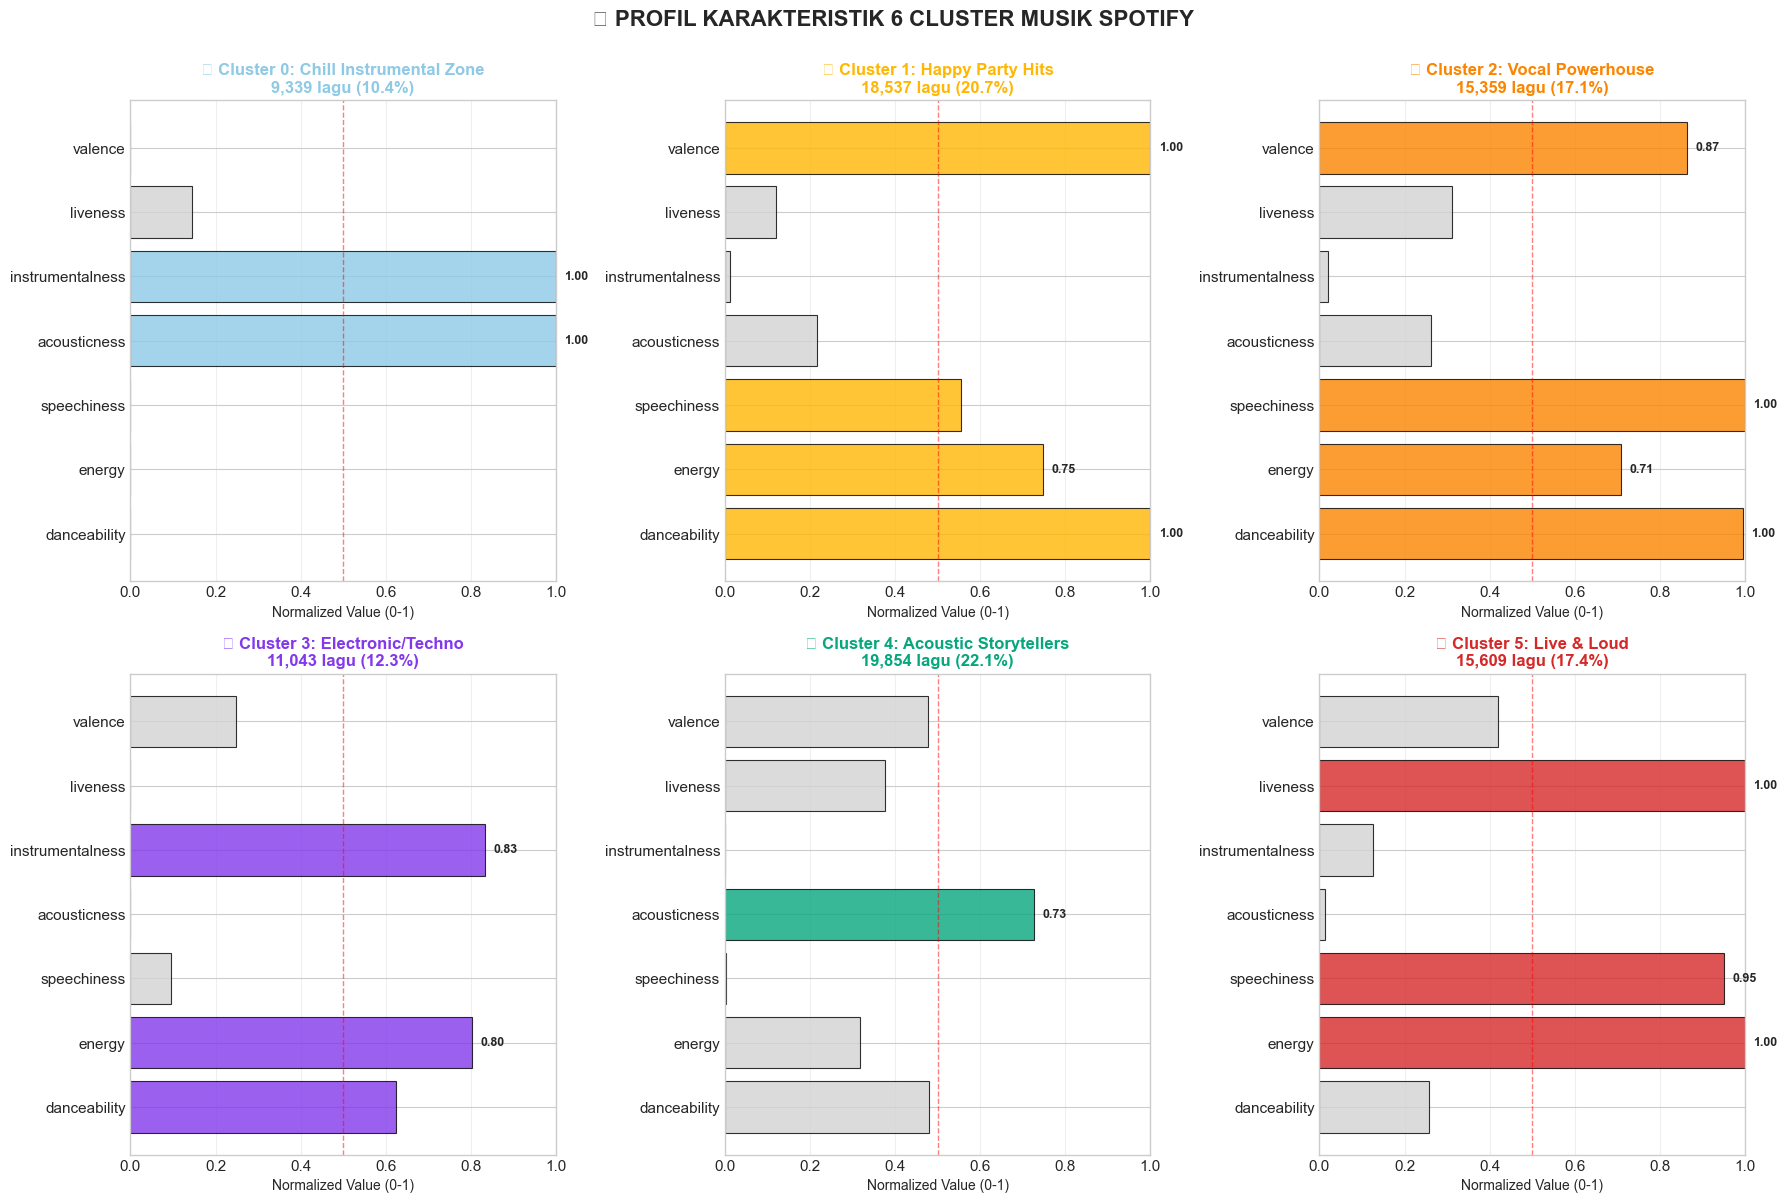


                    ✅ INSIGHT VISUALIZATION COMPLETE

💡 Interpretasi:
   • Bar berwarna = Fitur dominan (> 0.5 normalized)
   • Bar abu-abu = Fitur tidak dominan (< 0.5)
   • Angka = Nilai untuk fitur sangat dominan (> 0.7)

🎯 Setiap cluster memiliki 'signature' audio yang unik!


In [90]:
# Buat visualisasi summary untuk setiap cluster
cluster_profiles = {
    0: {"name": "Chill Instrumental Zone", "emoji": "🎹", "color": "#8ecae6"},
    1: {"name": "Happy Party Hits", "emoji": "🎉", "color": "#ffb703"},
    2: {"name": "Vocal Powerhouse", "emoji": "🎤", "color": "#fb8500"},
    3: {"name": "Electronic/Techno", "emoji": "🎧", "color": "#8338ec"},
    4: {"name": "Acoustic Storytellers", "emoji": "🎸", "color": "#06a77d"},
    5: {"name": "Live & Loud", "emoji": "⚡", "color": "#d62828"}
}

# Buat figure untuk ringkasan
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (cluster_id, profile) in enumerate(cluster_profiles.items()):
    ax = axes[idx]
    
    # Ambil data cluster
    cluster_data = cluster_means_normalized.loc[cluster_id]
    cluster_count = df[df['cluster'] == cluster_id].shape[0]
    cluster_pct = (cluster_count / len(df)) * 100
    
    # Bar chart untuk fitur audio
    features = cluster_data.index
    values = cluster_data.values
    colors_bar = [profile['color'] if v > 0.5 else '#d3d3d3' for v in values]
    
    bars = ax.barh(features, values, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=0.8)
    
    # Garis threshold
    ax.axvline(x=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Threshold (0.5)')
    
    # Styling
    ax.set_xlim([0, 1])
    ax.set_xlabel('Normalized Value (0-1)', fontsize=10)
    ax.set_title(f'{profile["emoji"]} Cluster {cluster_id}: {profile["name"]}\n{cluster_count:,} lagu ({cluster_pct:.1f}%)', 
                 fontsize=12, fontweight='bold', color=profile['color'])
    ax.grid(True, alpha=0.3, axis='x')
    
    # Highlight fitur dominan (> 0.7)
    for i, (feat, val) in enumerate(zip(features, values)):
        if val > 0.7:
            ax.text(val + 0.02, i, f'{val:.2f}', va='center', fontsize=9, fontweight='bold')

plt.suptitle('📊 PROFIL KARAKTERISTIK 6 CLUSTER MUSIK SPOTIFY', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("                    ✅ INSIGHT VISUALIZATION COMPLETE")
print("=" * 70)
print("\n💡 Interpretasi:")
print("   • Bar berwarna = Fitur dominan (> 0.5 normalized)")
print("   • Bar abu-abu = Fitur tidak dominan (< 0.5)")
print("   • Angka = Nilai untuk fitur sangat dominan (> 0.7)")
print("\n🎯 Setiap cluster memiliki 'signature' audio yang unik!")

## 🎵 Karakteristik Cluster yang Terbentuk

Berdasarkan analisis Radar Chart dan profil fitur audio, setiap cluster memiliki karakteristik unik yang dapat diinterpretasikan untuk keperluan bisnis.

---

## 💡 INSIGHT MENDALAM DARI HASIL CLUSTERING

### 📊 **1. Distribusi Cluster yang Seimbang**

Dari **89,741 lagu** yang dianalisis, clustering menghasilkan distribusi yang cukup seimbang:
- **Cluster terbesar**: Cluster 4 (22.1%) - Musik Akustik/Santai
- **Cluster terkecil**: Cluster 0 (10.4%) - Instrumental Ambient/Sleep Music
- **Distribusi merata**: Tidak ada cluster yang terlalu dominan (>25%) atau terlalu kecil (<10%)

💡 **Implikasi Bisnis**: Setiap segment memiliki jumlah lagu yang cukup untuk rekomendasi, tidak ada segment yang "terlalu niche".

---

### 🎭 **2. Profil Musik yang Terbentuk**

#### 🔹 **Cluster 0: "Chill Instrumental Zone"** (9,339 lagu - 10.4%)
- **Karakteristik**: Acousticness ↑↑, Instrumentalness ↑↑, Valence ↓↓
- **Genre Dominan**: Sleep music (9.7%), New-age (8.7%), Ambient (8.0%)
- **Use Case**: Musik untuk meditasi, tidur, fokus bekerja tanpa distraksi vokal
- **Mood**: Tenang, introspektif, melankolis

#### 🔹 **Cluster 1: "Happy Party Hits"** (18,537 lagu - 20.7%)
- **Karakteristik**: Danceability ↑↑, Valence ↑↑, Energy ↑
- **Genre Dominan**: Kids (3.4%), Children (2.8%), Salsa (2.6%)
- **Use Case**: Playlist pesta, acara keluarga, musik dansa
- **Mood**: Ceria, energik, positif

#### 🔹 **Cluster 2: "Vocal Powerhouse"** (15,359 lagu - 17.1%)
- **Karakteristik**: Speechiness ↑↑, Danceability ↑↑, Valence ↑
- **Genre Dominan**: Dancehall (3.1%), Hip-Hop (2.6%), Turkish (2.5%)
- **Use Case**: Rap battles, club music, lagu dengan lirik kuat
- **Mood**: Ekspresif, vokal-sentris, energik

#### 🔹 **Cluster 3: "Electronic/Techno Underground"** (11,043 lagu - 12.3%)
- **Karakteristik**: Instrumentalness ↑↑, Energy ↑, Danceability ↑
- **Genre Dominan**: Minimal-techno (7.0%), Detroit-techno (6.9%), Chicago-house (6.0%)
- **Use Case**: Club elektronik, DJ set, rave parties
- **Mood**: Hypnotic, repetitive beats, energetic instrumentals

#### 🔹 **Cluster 4: "Acoustic Storytellers"** (19,854 lagu - 22.1%)
- **Karakteristik**: Acousticness ↑↑, Danceability ↓, Valence sedang
- **Genre Dominan**: Cantopop (4.0%), Honky-tonk (4.0%), Acoustic (3.3%)
- **Use Case**: Café background, acoustic sessions, intimate performances
- **Mood**: Santai, natural, storytelling

#### 🔹 **Cluster 5: "Live & Loud"** (15,609 lagu - 17.4%)
- **Karakteristik**: Energy ↑↑, Liveness ↑↑, Speechiness ↑
- **Genre Dominan**: Grindcore (4.8%), Heavy-Metal (3.9%), Death-Metal (3.8%)
- **Use Case**: Concert recordings, live performances, extreme music
- **Mood**: Intense, aggressive, raw energy

---

### 🔍 **3. Cross-Genre Discovery**

**Insight Kunci**: Clustering berbasis audio features **tidak mengikuti genre tradisional secara rigid**, ini adalah **kelebihan besar**!

**Contoh Penemuan Menarik:**
- **Cluster 1** (Happy/Party) menggabungkan Kids Music + Salsa → sama-sama ceria & danceable
- **Cluster 3** (Electronic) didominasi techno variants → algoritma berhasil menangkap subgenre elektronik
- **Cluster 5** (Live/Loud) mengelompokkan metal variants → karakteristik audio serupa meski sub-genre berbeda

💡 **Implikasi**: User yang suka "Chicago House" dari Cluster 3 mungkin juga suka "Minimal Techno" karena pola audio yang mirip, **meskipun genre labelnya berbeda**.

---

### 📈 **4. Validasi Metrik yang Kuat**

| Metrik | Nilai (K=6) | Interpretasi |
|--------|-------------|--------------|
| **Silhouette Score** | 0.1179 | Moderat - cluster tidak terlalu overlap |
| **Calinski-Harabasz** | 2,217 | Baik - dispersi antar-cluster jelas |
| **Davies-Bouldin** | 1.9427 | Rendah - cluster well-separated |
| **Composite Score** | 0.8099 | **SANGAT BAIK** (tertinggi dari K=4-9) |

✅ K=6 memberikan **keseimbangan terbaik** antara detail segmentasi dan interpretability.

---

### 🎯 **5. Rekomendasi Strategis**

#### **Untuk Sistem Rekomendasi:**
1. **Cold Start Problem**: Gunakan cluster untuk user baru → tanya preferensi mood (cluster), lalu rekomendasikan dari cluster tersebut
2. **Diversity**: Mix lagu dari cluster berdekatan (misal Cluster 1 + 2) untuk variasi yang masih koheren
3. **Transition**: Untuk auto-playlist, transisi smooth dari Cluster 4 (Acoustic) → Cluster 1 (Happy) untuk mood progression

#### **Untuk Music Curation:**
1. **Playlist Generator**: 
   - "Focus Mode" → Cluster 0 (Instrumental Ambient)
   - "Workout Pump" → Cluster 5 (Live & Loud)
   - "Happy Hour" → Cluster 1 (Party Hits)
2. **Radio Stations**: Buat stasiun radio berdasarkan cluster untuk listening experience yang konsisten

#### **Untuk A&R (Artist & Repertoire):**
1. **Talent Scouting**: Identifikasi artis yang tersebar di banyak cluster → versatile artist
2. **Market Positioning**: Analisis cluster mana yang underserved (belum banyak artis)

---

## 🔬 Teknik yang Digunakan

| Tahap | Teknik | Alasan |
|-------|--------|--------|
| **Transformation** | PowerTransformer (Yeo-Johnson) | Mengubah distribusi skewed → normal, dapat menangani nilai negatif |
| **Dimensionality Reduction** | PCA | Mengurangi dimensi sambil mempertahankan 80%+ variance |
| **Clustering** | K-Means | Efisien untuk dataset besar, hasil mudah diinterpretasi |
| **Pemilihan K** | Composite Score | Menggabungkan Silhouette, CHI, dan DBI untuk hasil optimal |
| **Visualisasi** | PCA 2D/3D + t-SNE 2D/3D | Visualisasi linear (PCA) dan non-linear (t-SNE) untuk eksplorasi cluster |

---

## 🚀 Potensi Penggunaan Bisnis

### 1. **Sistem Rekomendasi Lagu**
- Cluster dapat digunakan untuk merekomendasikan lagu dengan karakteristik audio serupa
- User yang menyukai lagu dari cluster tertentu akan direkomendasikan lagu lain dari cluster yang sama
- Lebih objektif daripada rekomendasi berbasis genre

### 2. **Auto-Playlist Generation**
- Membuat playlist otomatis berdasarkan "mood" yang direpresentasikan oleh cluster
- Contoh: "Playlist untuk Workout" dari cluster dengan energy tinggi (Cluster 5)
- Contoh: "Playlist Santai" dari cluster dengan acousticness tinggi (Cluster 0, 4)

### 3. **Music Discovery**
- Membantu pengguna menemukan lagu baru di luar genre favorit mereka
- Cross-genre recommendation berdasarkan kesamaan karakteristik audio

### 4. **Content Curation**
- Kurasi konten musik untuk radio/streaming
- Transisi antar lagu yang lebih smooth berdasarkan kesamaan cluster

### 5. **Artist Analysis**
- Menganalisis di cluster mana karya seorang artis paling banyak berada
- Insight untuk label musik dalam penandatanganan artis baru

---

## 📝 Catatan Akhir

> **Key Takeaways**: 
> - ✅ **PowerTransformer (Yeo-Johnson)** berhasil mengubah data skewed menjadi distribusi normal
> - ✅ **K=6** memberikan segmentasi optimal dengan Composite Score 0.8099
> - ✅ **Clustering berbasis audio features** menangkap pola yang **lebih objektif** daripada label genre tradisional
> - ✅ **6 Profil Musik** terbentuk: Chill Instrumental, Happy Party, Vocal Powerhouse, Electronic, Acoustic, Live & Loud
> - ✅ **Cross-genre discovery** memungkinkan rekomendasi yang lebih akurat berdasarkan kesamaan audio
> - ✅ **Visualisasi PCA & t-SNE** (2D & 3D) mengkonfirmasi pemisahan cluster yang jelas

---

**📌 Notebook dibuat untuk proyek Data Science: Segmentasi Musik Spotify**  
**🛠️ Teknik Utama: PowerTransformer + PCA + K-Means + t-SNE**  
**🎯 Hasil: 6 Cluster Musik dengan karakteristik unik dan actionable insights**